# Partie 2 : Analyses exploratoires des données

Une fois le nettoyage des données effectuées, on va pouvoir passer à l'étape des analyses exploratoires des données. Grâce à cette étape, on va pouvoir se familiariser avec nos données, découvrir l'état des lieux de l'accès à l'éducation à travers le monde ainsi que la santé économique des pays de notre échantillon. C'est aussi dans cette étape que l'on va pouvoir faire une première sélection des variables qui peuvent présenter un intérêt à la réalisation de notre étude. 

In [1]:
# Liste des librairies importées
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.mlab as mlab
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
import time

from sklearn import decomposition, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
########################
##FONCTIONS DE CALCULS##
########################

def distrib_normalize(data, i):
    """Fonction qui trace la distribution d'une variable et qui calcule la symétrie, 
    le coefficient d'applatissement et le respect à une loi statistique : ici la loi normale
    
    Entrée : 
    - Nom du dataframe
    - Colonne d'une variable
    
    Sortie : 
    - Graphique de distribution
    - Résultat de la symétrie
    - Résultat du coefficient d'applatissement
    - Résultat à l'adéquation à la loi normale
  """
    print(i.capitalize())
    sns.displot(data[i], kde=True)
    plt.axvline(x=data[i].mean(), label='Moyenne', linestyle='-', color='r', linewidth=2)
    plt.axvline(x=data[i].median(), label='Médiane', linestyle='--', color='b', linewidth=2)
    plt.show()
    print('Skewness: ', str(st.stats.skew(data[i])))
    print('Kurtosis: ', str(st.stats.kurtosis(data[i])))
    print(str(ks_2samp(data[i],list(np.random.normal(np.mean(data[i]), np.std(data[i]), 1000)))))
    print()

########################
##FONCTIONS DE DESSINS##
########################

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
  """
  Fonction qui trace le cercle de corrélation de l'ACP

  Entrées : 
  - Coordonnées des points de l'ACP
  - Nombre de composantes
  - Fonction de l'ACP dans sklearn
  - Composantes que l'on souhaite représenter

  Sortie : 
  - Cercle de corrélation  
  """
  for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
      if d2 < n_comp:

          # initialisation de la figure
          fig, ax = plt.subplots(figsize=(10,10))

          # détermination des limites du graphique
          if lims is not None :
              xmin, xmax, ymin, ymax = lims
          elif pcs.shape[1] < 30 :
              xmin, xmax, ymin, ymax = -1, 1, -1, 1
          else :
              xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

          # affichage des flèches
          # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
          if pcs.shape[1] < 30 :
              plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                pcs[d1,:], pcs[d2,:], 
                angles='xy', scale_units='xy', scale=1, color="grey")
              # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
          else:
              lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
              ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
          # affichage des noms des variables  
          if labels is not None:  
              for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                  if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                    plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
          # affichage du cercle
          an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
          plt.plot(np.cos(an), np.sin(an))
          plt.axis('equal')

          # définition des limites du graphique
          plt.xlim(xmin, xmax)
          plt.ylim(ymin, ymax)
        
          # affichage des lignes horizontales et verticales
          plt.plot([-1, 1], [0, 0], color='grey', ls='--')
          plt.plot([0, 0], [-1, 1], color='grey', ls='--')

          # nom des axes, avec le pourcentage d'inertie expliqué
          plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
          plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

          plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
          plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
  """Fonction qui trace la représentation des individus sur les plans factoriels

  Entrées :
  - Individus projetés
  - Nombre de composante
  - Fonction de l'ACP issue de Sklearn
  - Composantes que l'on souhaite représenter
  - Variables illustratives

  Sortie : 
  - Projection des individus sur les composantes sélectionnées
  """
  for d1,d2 in axis_ranks:
    if d2 < n_comp:
      # initialisation de la figure       
      fig = plt.figure(figsize=(7,6))
        
      # affichage des points
      if illustrative_var is None:
        plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
      else:
        illustrative_var = np.array(illustrative_var)
      for value in np.unique(illustrative_var):
        selected = np.where(illustrative_var == value)
        plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
      plt.legend()

      # affichage des labels des points
      if labels is not None:
        for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
          plt.text(x, y, labels[i],
          fontsize='14', ha='center',va='center') 
                
      # détermination des limites du graphique
      boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
      plt.xlim([-boundary,boundary])
      plt.ylim([-boundary,boundary])
        
      # affichage des lignes horizontales et verticales
      plt.plot([-100, 100], [0, 0], color='grey', ls='--')
      plt.plot([0, 0], [-100, 100], color='grey', ls='--')

      # nom des axes, avec le pourcentage d'inertie expliqué
      plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
      plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

      plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
      plt.show(block=False)

In [3]:
# paramétrage de l'environnement graphique
sns.set_palette('Set2')

## L'éducation à travers le monde

Les données utilisées dans la suite de cette analyse ont été téléchargés sur le site de la banque mondiale. Elles regroupent les données de plusieurs années (2001 à 2020). Les valeurs présentes ci-dessous correspondent à la moyenne calculée sur ces 20 dernières années. Ainsi, cela a permis d'obtenir des données pour la plupart des pays. Pour plus d'informations sur le nettoyage de ces données, les étapes sont détaillées dans un notebook : data_cleaning.

In [4]:
# Chargement des données

df_edu = pd.read_csv('data_scol.csv', sep=';')

# Retrait de la colonne 'Unnamed: 0' et modification des , en .
df_edu.drop('Unnamed: 0', axis=1, inplace=True)
df_edu = df_edu.apply(lambda x: x.str.replace(',','.'))

# Transformation des valeurs en float
cols = df_edu.columns.to_list()
cols.pop(0)
cols.pop(0)
for i in cols:
    df_edu[i] = df_edu[i].astype('float')

df_edu.head()

,Pays,Code ISO,Accession à l’enseignement secondaire (%),Adolescents non scolarisés (% des adolescents en âge de fréquenter le 1er cycle du secondaire),Emploi des enfants dans l’agriculture (% d’enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur),Emploi d’enfants dans le secteur des services (% des enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur),Emploi d’enfants dans le secteur manufacturier (% des enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur),"Enfants actifs économiquement, qui travaillent uniquement (% de tous les enfants de 7 à 14 ans)","Enfants actifs économiquement, qui étudient et travaillent (% de tous les enfants économiquement actifs de 7 à 14 ans)","Enfants actifs économiquement, total (% des enfants âgés de 7 à 14 ans)",...,Ratio femmes/hommes des inscriptions dans l’enseignement supérieur,Ratio filles/garçons des inscriptions au primaire (%),Ratio filles/garçons des inscriptions au secondaire (%),"Taux d emploi, 15-24 ans (%) (estimation nationale)","Taux d’achèvement de l’école primaire, total (% du groupe d’âge pertinent)","Taux d’achèvement du premier cycle des études secondaires, total (% du groupe d’âge pertinent)",Taux d’alphabétisation des jeunes (% des jeunes âgés de 15 à 24 ans),"Taux d’alphabétisation, total des adultes (% des personnes âgées de 15 ans et plus)",Âge de début de l’école primaire (années),Âge de début de l’école secondaire (années)
0,Afghanistan,AFG,89.783073,NaN,NaN,NaN,NaN,50.000000,50.000000,9.300000,...,0.294833,0.599088,0.442298,41.567500,83.511772,43.786143,56.205299,37.234284,7.0,13.0
1,Afrique du Sud,ZAF,96.816158,13.785806,NaN,NaN,NaN,NaN,NaN,NaN,...,1.296527,0.963646,1.068906,12.696842,90.047670,80.105780,98.176697,92.109441,7.0,14.0
2,Albanie,ALB,98.833753,4.755447,83.85,9.25,1.26,5.900000,94.100000,13.750000,...,1.308677,1.016700,0.982993,23.374615,96.282486,92.401003,99.123790,97.377008,6.0,10.6
3,Algérie,DZA,96.591529,NaN,NaN,NaN,NaN,4.508655,95.491345,7.500764,...,1.299649,0.938633,1.063733,19.998572,98.099923,71.474606,93.277674,74.766516,6.0,11.4
4,Allemagne,DEU,99.627867,2.639915,NaN,NaN,NaN,NaN,NaN,NaN,...,0.985777,0.995832,0.959991,45.656316,100.295240,82.629459,NaN,NaN,6.0,10.0


In [5]:
# Affichage du nombre de lignes et de colonne du df
df_edu.shape

(204, 25)

In [6]:
# Affichage du nombre de pays et de leurs noms
country = df_edu['Pays'].unique()
print('Nombre total de pays :', len(country))
print(sorted(country))

Nombre total de pays : 204
['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne', 'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine', 'Arménie', 'Aruba', 'Australie', 'Autriche', 'Azerbaïdjan', 'Bahamas', 'Bahreïn', 'Bangladesh', 'Barbade', 'Belgique', 'Belize', 'Bermudes', 'Bhoutan', 'Bolivie', 'Bosnie-Herzégovine', 'Botswana', 'Brunéi Darussalam', 'Brésil', 'Bulgarie', 'Burkina Faso', 'Burundi', 'Bélarus', 'Bénin', 'Cabo Verde', 'Cambodge', 'Cameroun', 'Canada', 'Chili', 'Chine', 'Chine. RAS de Hong Kong', 'Chypre', 'Cisjordanie et Gaza', 'Colombie', 'Comores', 'Congo. République du', 'Congo. République démocratique du', 'Corée. République de', 'Corée. République démocratique de', 'Costa Rica', 'Croatie', 'Cuba', 'Curacao', "Côte d'Ivoire", 'Danemark', 'Djibouti', 'Dominique', 'El Salvador', 'Espagne', 'Estonie', 'Eswatini', 'Fidji', 'Finlande', 'France', 'Fédération de Russie', 'Gabon', 'Gambie', 'Ghana', 'Gibraltar', 'Grenade', 'Grèce', 'Guatemala', 'Guiné

In [7]:
# Affichage des pourcentages de valeurs NaN
df_edu.isnull().mean()

Pays                                                                                                                              0.000000
Code ISO                                                                                                                          0.000000
Accession à l’enseignement secondaire (%)                                                                                         0.127451
Adolescents non scolarisés (% des adolescents en âge de fréquenter le 1er cycle du secondaire)                                    0.112745
Emploi des enfants dans l’agriculture (% d’enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur)               0.696078
Emploi d’enfants dans le secteur des services (% des enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur)     0.696078
Emploi d’enfants dans le secteur manufacturier (% des enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur)    0.696078
Enfants actifs économiqueme

In [8]:
# Retrait des variables avec plus de 70% de valeurs manquantes
df_edu.drop(['Emploi des enfants dans l’agriculture (% d’enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur)',
             'Emploi d’enfants dans le secteur des services (% des enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur)',
             'Emploi d’enfants dans le secteur manufacturier (% des enfants économiquement actifs de 7 à 14 ans travaillant dans ce secteur)',], axis=1, inplace=True)

In [9]:
# Retrait des variables avec plus de 55% de valeurs manquantes
df_edu.drop(['Enfants actifs économiquement, qui travaillent uniquement (% de tous les enfants de 7 à 14 ans)',
             'Enfants actifs économiquement, qui étudient et travaillent (% de tous les enfants économiquement actifs de 7 à 14 ans)',
             'Enfants actifs économiquement, total (% des enfants âgés de 7 à 14 ans)'], axis = 1, inplace = True)

In [10]:
df_edu.shape

(204, 19)

Notre jeu de données porte sur 204 pays à travers le monde. On retrouve au total 17 variables qui nous permettent de décrire la situation de l'éducation à travers le monde. 

### Analyses descriptives

Après avoir regardé la composition de notre jeu de données, on va s'intéresser à la description de nos données pour savoir ce qu'elles tentent de traduire. 

#### Analyses univariées

In [11]:
cols = df_edu.columns.to_list()
cols.pop(0)
cols.pop(0)
print(cols)

['Accession à l’enseignement secondaire (%)', 'Adolescents non scolarisés (% des adolescents en âge de fréquenter le 1er cycle du secondaire)', 'Enfants non scolarisés (% des enfants d’âge primaire)', 'Inscriptions à l’école, enseignement supérieur (%\xa0brut)', 'Inscriptions à l’école, primaire (%\xa0brut)', 'Inscriptions à l’école, préscolaire, (%\xa0brut)', 'Inscriptions à l’école, secondaire (%\xa0brut)', 'Ratio femmes/hommes des inscriptions dans l’enseignement supérieur', 'Ratio filles/garçons des inscriptions au primaire (%)', 'Ratio filles/garçons des inscriptions au secondaire (%)', 'Taux d emploi, 15-24\xa0ans (%) (estimation nationale)', 'Taux d’achèvement de l’école primaire, total (%\xa0du groupe d’âge pertinent)', 'Taux d’achèvement du premier cycle des études secondaires, total (%\xa0du groupe d’âge pertinent)', 'Taux d’alphabétisation des jeunes (%\xa0des jeunes âgés de 15 à 24 ans)', 'Taux d’alphabétisation, total des adultes (%\xa0des personnes âgées de 15 ans et plus

##### Distribution des variables

Accession à l’enseignement secondaire (%)


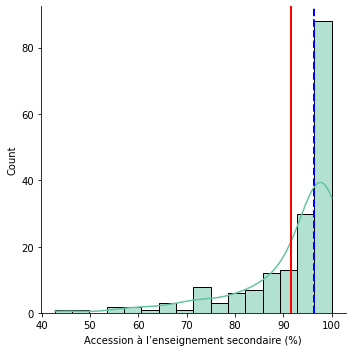

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.27627450980392154, pvalue=6.622147274981671e-12)

Adolescents non scolarisés (% des adolescents en âge de fréquenter le 1er cycle du secondaire)


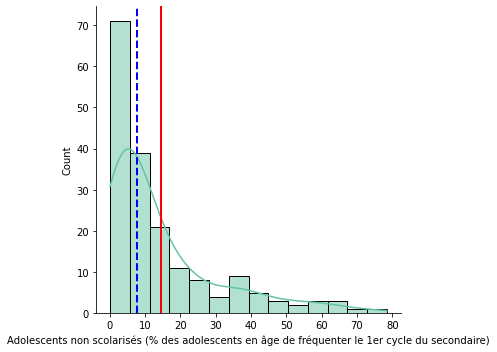

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.19409803921568627, pvalue=4.557446362962736e-06)

Enfants non scolarisés (% des enfants d’âge primaire)


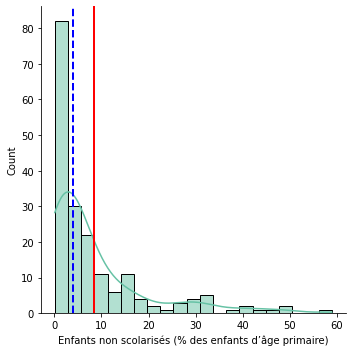

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.206, pvalue=8.785901571828347e-07)

Inscriptions à l’école, enseignement supérieur (% brut)


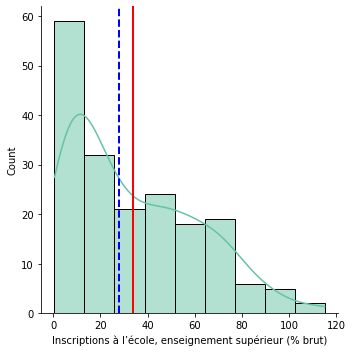

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.11523529411764706, pvalue=0.020233148103231402)

Inscriptions à l’école, primaire (% brut)


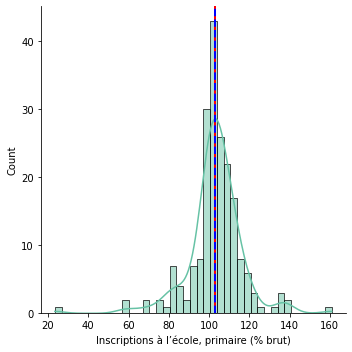

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.19662745098039217, pvalue=3.2400558748202357e-06)

Inscriptions à l’école, préscolaire, (% brut)


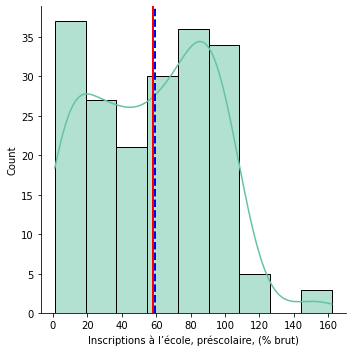

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.10194117647058823, pvalue=0.05454259799943861)

Inscriptions à l’école, secondaire (% brut)


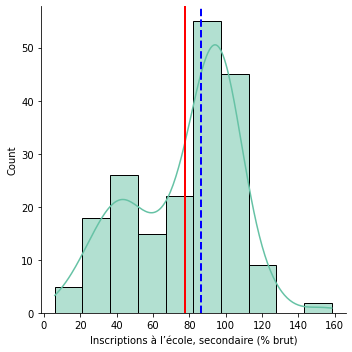

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.1417450980392157, pvalue=0.0019477262542269003)

Ratio femmes/hommes des inscriptions dans l’enseignement supérieur


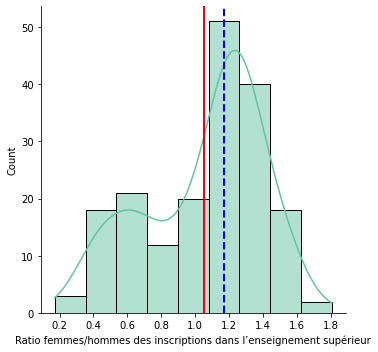

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.13601960784313724, pvalue=0.0033643357804380436)

Ratio filles/garçons des inscriptions au primaire (%)


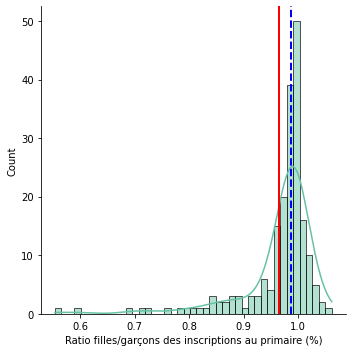

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.2651176470588235, pvalue=5.4751536637809295e-11)

Ratio filles/garçons des inscriptions au secondaire (%)


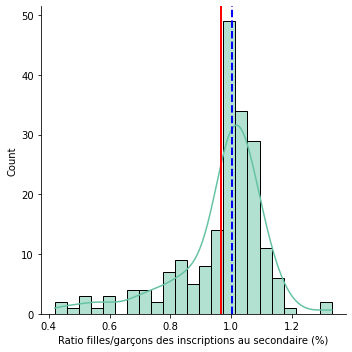

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.23068627450980392, pvalue=2.0937516831409653e-08)

Taux d emploi, 15-24 ans (%) (estimation nationale)


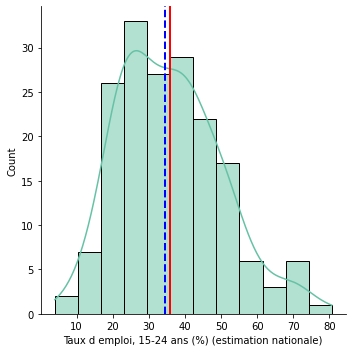

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.1508627450980392, pvalue=0.0007782904307735983)

Taux d’achèvement de l’école primaire, total (% du groupe d’âge pertinent)


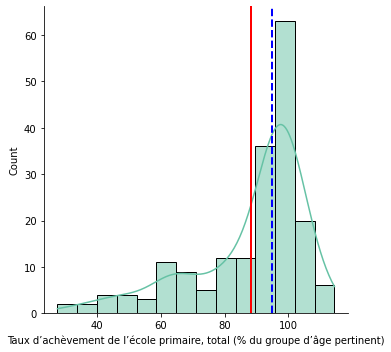

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.22815686274509803, pvalue=3.1357079377514196e-08)

Taux d’achèvement du premier cycle des études secondaires, total (% du groupe d’âge pertinent)


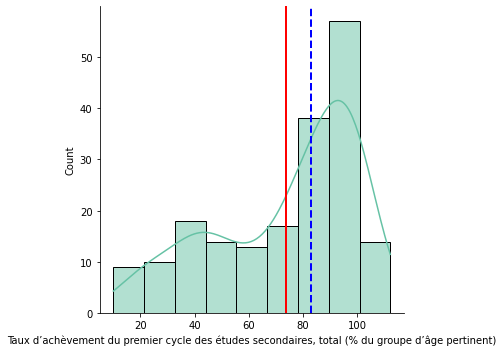

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.1936078431372549, pvalue=4.8670856787058625e-06)

Taux d’alphabétisation des jeunes (% des jeunes âgés de 15 à 24 ans)


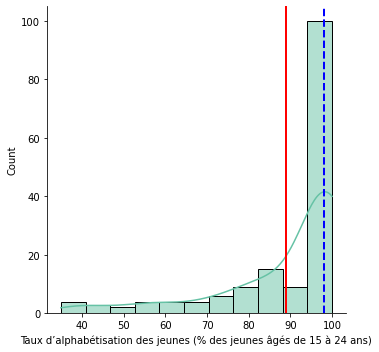

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.3289607843137255, pvalue=0.0)

Taux d’alphabétisation, total des adultes (% des personnes âgées de 15 ans et plus)


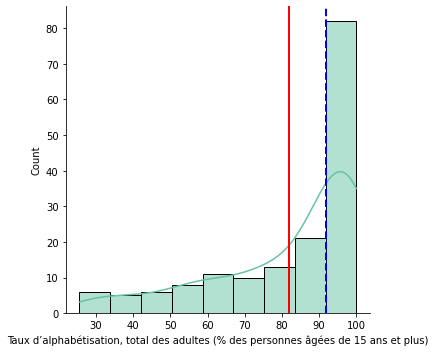

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.29015686274509805, pvalue=4.1944225870338414e-13)

Âge de début de l’école primaire (années)


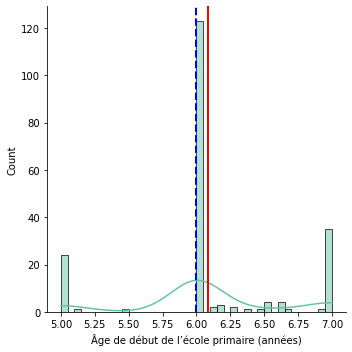

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.30154901960784314, pvalue=3.985700658404312e-14)

Âge de début de l’école secondaire (années)


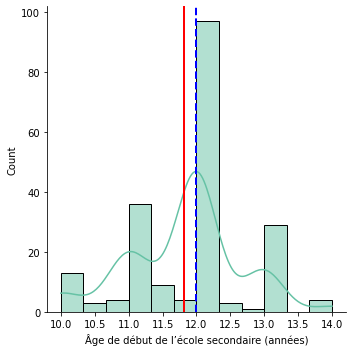

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.24276470588235294, pvalue=2.8708859733939107e-09)



In [12]:
for elt in cols:
    distrib_normalize(df_edu, elt)

L'analyse de la distribution (autant graphique que par le test de Kolmogorov-Smirnov) nous indique qu'aucune de nos variables ne suit la loi normale. Cependant, le nombre d'individus de notre échantillon étant grand (204), on considère que nos distributions tendent vers la loi normale (loi des grands nombres).

##### Statistiques descriptives des variables

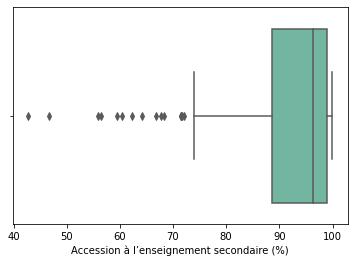

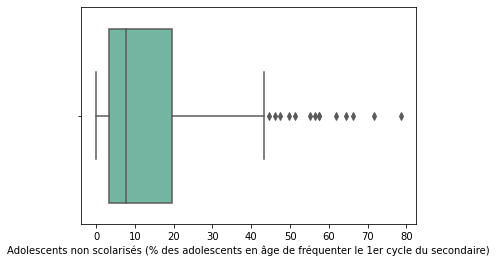

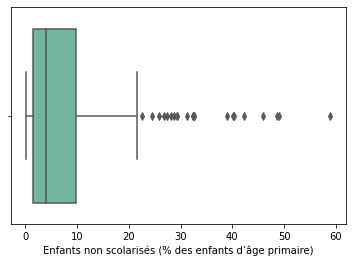

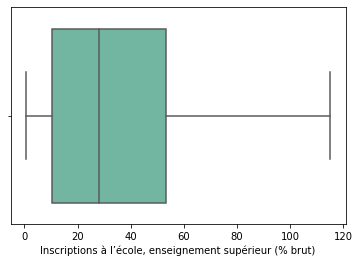

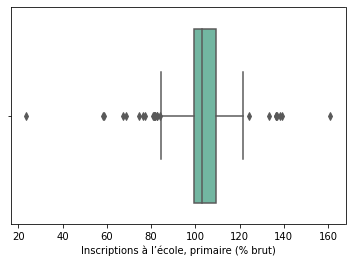

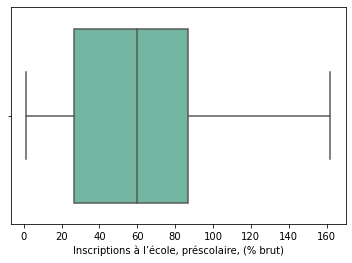

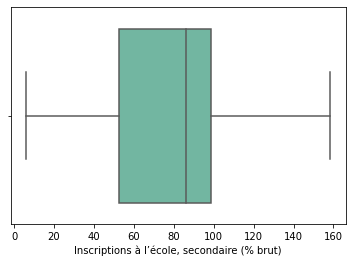

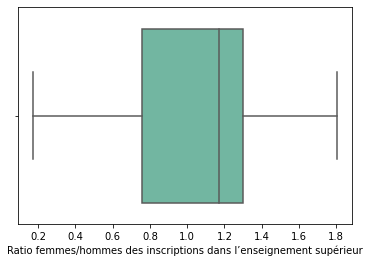

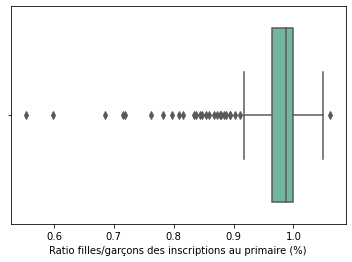

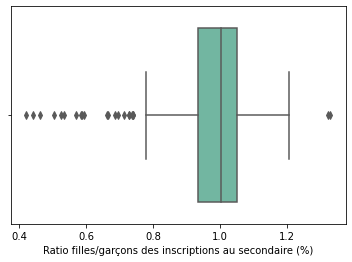

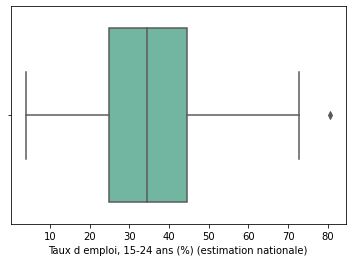

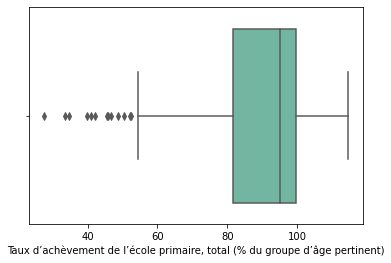

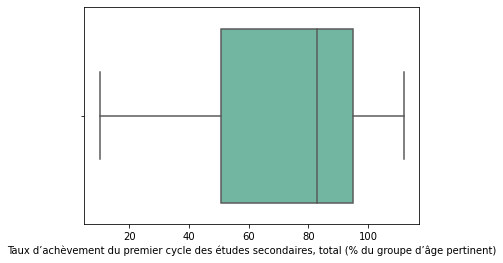

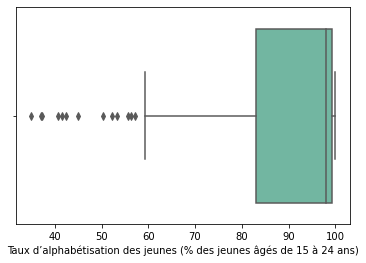

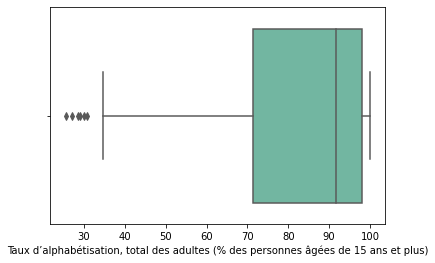

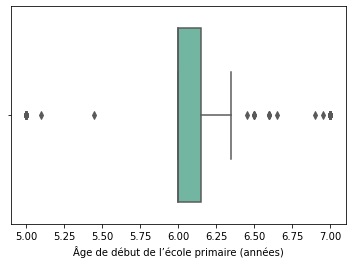

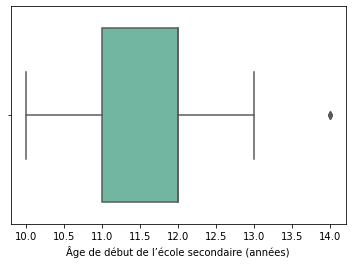

In [13]:
for elt in cols:
    sns.boxplot(x=elt, data=df_edu)
    plt.show()

In [14]:
# Calcul des médianes pour chaque variable
df_edu.median().T

Accession à l’enseignement secondaire (%)                                                          96.269669
Adolescents non scolarisés (% des adolescents en âge de fréquenter le 1er cycle du secondaire)      7.781353
Enfants non scolarisés (% des enfants d’âge primaire)                                               3.996940
Inscriptions à l’école, enseignement supérieur (% brut)                                            28.107104
Inscriptions à l’école, primaire (% brut)                                                         102.884563
Inscriptions à l’école, préscolaire, (% brut)                                                      59.574936
Inscriptions à l’école, secondaire (% brut)                                                        86.168283
Ratio femmes/hommes des inscriptions dans l’enseignement supérieur                                  1.171020
Ratio filles/garçons des inscriptions au primaire (%)                                               0.987594
Ratio filles/garçon

In [15]:
# Calcul des moyennes pour chaque variable
df_edu.mean().T

Accession à l’enseignement secondaire (%)                                                          91.608771
Adolescents non scolarisés (% des adolescents en âge de fréquenter le 1er cycle du secondaire)     14.438381
Enfants non scolarisés (% des enfants d’âge primaire)                                               8.487379
Inscriptions à l’école, enseignement supérieur (% brut)                                            34.041937
Inscriptions à l’école, primaire (% brut)                                                         103.124497
Inscriptions à l’école, préscolaire, (% brut)                                                      58.199774
Inscriptions à l’école, secondaire (% brut)                                                        77.581115
Ratio femmes/hommes des inscriptions dans l’enseignement supérieur                                  1.054695
Ratio filles/garçons des inscriptions au primaire (%)                                               0.965015
Ratio filles/garçon

### Anayses bivariées

Après l'analyse de nos variables une à une, on s'intéresse au corrélation entre nos variables. Pour cela, on va créer une matrice de corrélation. 

In [16]:
df_edu2 = df_edu.copy()
df_edu2.columns = ['pays', 'code_pays', 'acces_ens_second', 'ado_non-scol', 'enfants_non-scol', 
                   'inscriptions_ens_sup', 'inscriptions_primaire', 'inscriptions_préscol', 'inscriptions_secondaire', 
                   'ratio_ens_sup', 'ratio_primaire', 'ratio_secondaire', 'tx_emploi_15-24', 
                   'tx_achevement_primaire', 'tx_achevement_secondaire', 'tx_alphabetisation_jeunes', 
                   'tx_alphabetisation_total', 'age_debut_primaire', 'age_debut_secondaire']

#### Matrice de corrélation

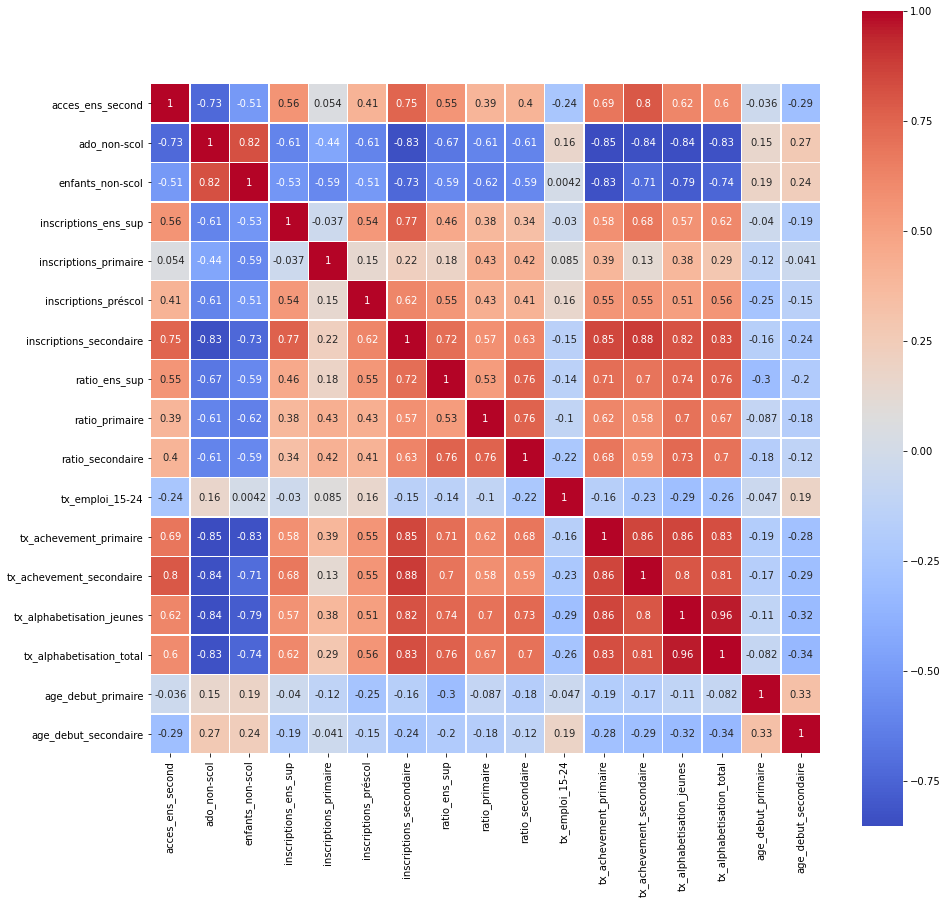

In [17]:
corrMatrix = df_edu2.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

A l'aide de cette première matrice, on peut supprimer les variables qui ont aucune corrélation avec les autres. Cela concerne le taux d'emploi des 15 à 24 ans, l'âge de début du primaire et l'âge de début du secondaire. 

In [18]:
# On enlève les variables qui n'ont aucune corrélation avec les autres
df_edu2.drop(['acces_ens_second', 'tx_emploi_15-24', 'age_debut_primaire', 'age_debut_secondaire'], axis=1, inplace=True)

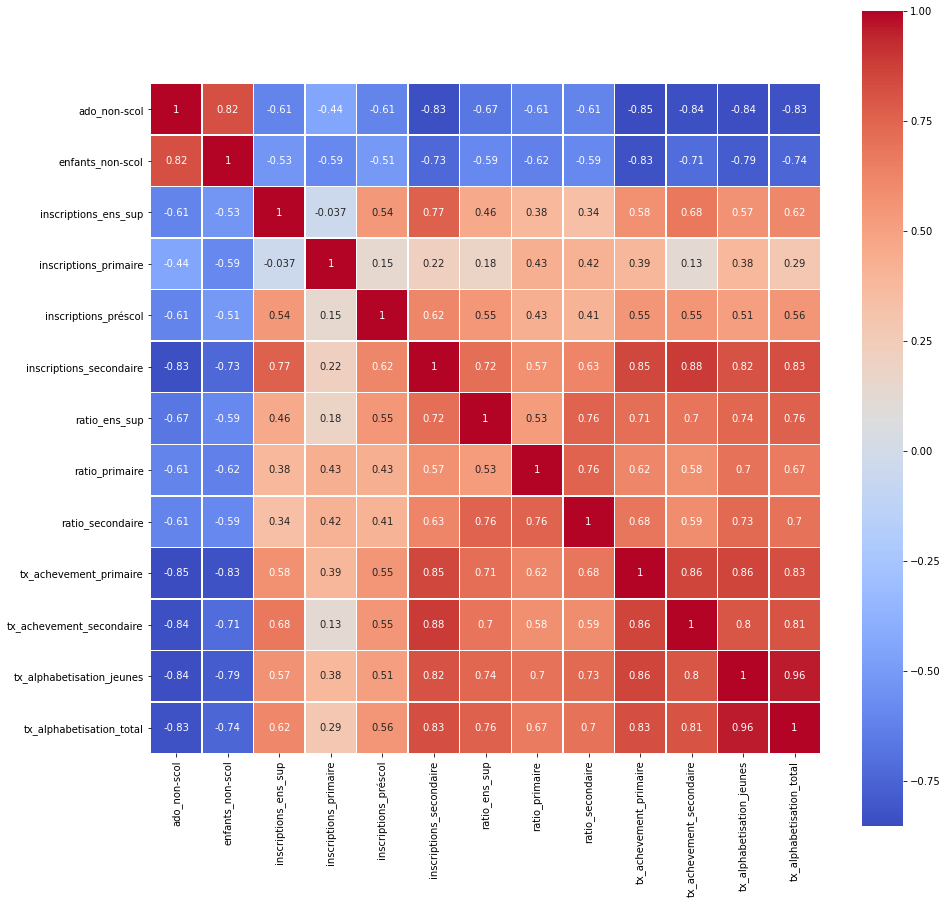

In [19]:
corrMatrix = df_edu2.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, linewidths=.5, annot=True, cmap='coolwarm')
plt.show()

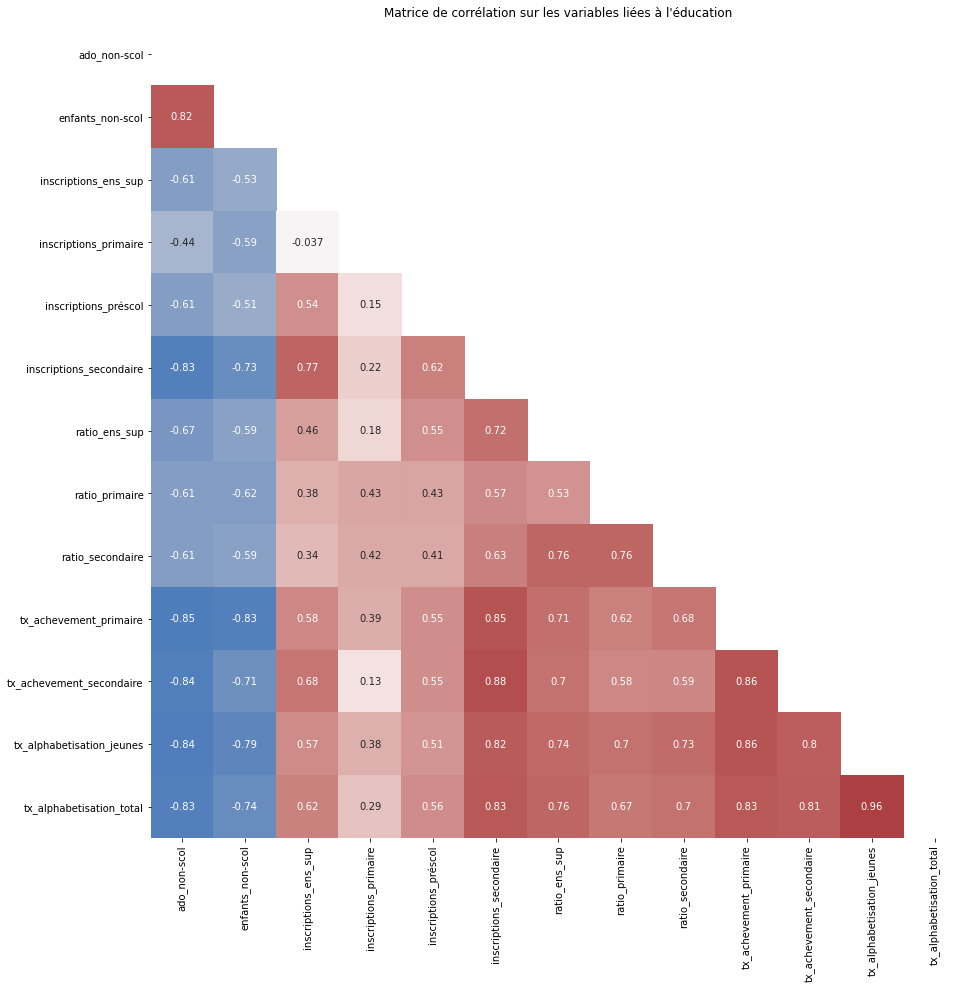

In [20]:
mask = np.triu(corrMatrix)

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, mask = mask, fmt = '.2g', annot=True, vmin=-1, vmax=1, cmap='vlag', center= 0, cbar=False)
plt.title('Matrice de corrélation sur les variables liées à l\'éducation')
plt.savefig('Corr_matrix_education.png')
plt.show()

## Analyse en composantes principales

On effectue une analyse en composantes principales pour déterminer les features qui composent notre jeu de données, ainsi que les pays qui contribuent le plus à ces features.

In [21]:
# Préprocessing des data
# On n'a au préalable supprimer les variables qui n'avaient aucune corrélation avec les autres
data_acp = df_edu2.set_index('pays')
data_acp.drop('code_pays', axis=1, inplace = True)

print(data_acp.shape)
n = data_acp.shape[0]
p = data_acp.shape[1]

(204, 13)


In [22]:
# Remplacement des valeurs nulles par la médiane
data_acp[data_acp.columns] = data_acp[data_acp.columns].apply(pd.to_numeric, errors='coerce')
data_acp = data_acp.fillna(data_acp.median())

# Normalisation des valeurs
sc = StandardScaler()
Z = sc.fit_transform(data_acp)

In [23]:
acp = PCA()
print(acp)

PCA()


In [24]:
coord = acp.fit_transform(Z)
print(acp.n_components_)

13


In [25]:
# Correction de la variance expliquée
eigval = (n-1)/n*acp.explained_variance_
print(eigval)

[8.07591105 1.3613372  0.85795589 0.6430516  0.5504053  0.40476305
 0.31916617 0.20056177 0.17631449 0.15941565 0.12408315 0.09282961
 0.03420506]


In [26]:
# proportion de valeurs expliquées
ratio = acp.explained_variance_ratio_ * 100
print(acp.explained_variance_ratio_)

[0.62122393 0.10471825 0.06599661 0.04946551 0.04233887 0.03113562
 0.02455124 0.01542783 0.01356265 0.01226274 0.00954486 0.00714074
 0.00263116]


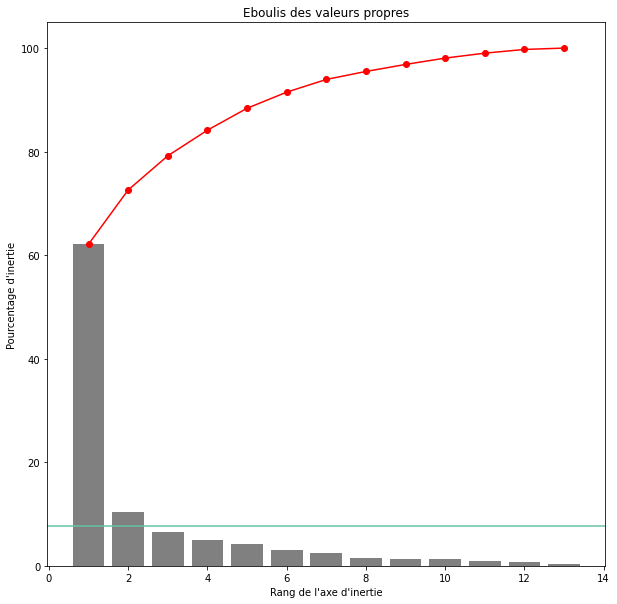

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
scree = acp.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.axhline(y=100/p)
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Selon le critère de Kaiser (100/p soit 100/14), le pourcentage d'inertie pour notre ACP doit être supérieur à 7,14%. On observe que la composante F1 explique à elle presque 61% et la composante F2 explique 10,4% de la variance. Notre analyse va donc se concentrer sur les composantes F1 et F2.

In [28]:
# contribution des individus dans l'inertie totale
di = np.sum(Z**2,axis=1)
print(pd.DataFrame({'ID':data_acp.index,'d_i':di}).sort_values('d_i', ascending=False))

                            ID         d_i
121                      Niger  104.995429
166              Soudan du Sud  100.908290
174                      Tchad   99.658743
146  République centrafricaine   89.370752
164                    Somalie   88.530907
..                         ...         ...
22                     Bolivie    1.504137
95                       Liban    1.432188
199                 Îles Féroé    1.336767
87                       Japon    1.336767
55                 El Salvador    0.873919

[204 rows x 2 columns]


Le Niger, le Soudan du Sud, le Tchad, la République centrafricaine et la Somalie sont les cinq pays qui contribuent le plus à l'inertie totale de notre analyse en composante principale. 

In [29]:
# qualité de représentation des individus - COS2
cos2 = coord**2

for j in range(p):
  cos2[:,j] = cos2[:,j]/di

qualite = pd.DataFrame({'id':data_acp.index,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1]})

print(qualite)

                            id   COS2_F1   COS2_F2
0                  Afghanistan  0.508984  0.045933
1               Afrique du Sud  0.125327  0.078479
2                      Albanie  0.773298  0.029030
3                      Algérie  0.081036  0.182289
4                    Allemagne  0.547753  0.113234
..                         ...       ...       ...
199                 Îles Féroé  0.765176  0.016577
200              Îles Marshall  0.040481  0.024432
201               Îles Salomon  0.101852  0.019302
202    Îles Turques-et-Caïques  0.000022  0.033266
203  Îles Vierges britanniques  0.642044  0.005485

[204 rows x 3 columns]


In [30]:
print(qualite.sort_values('COS2_F1', ascending=False).head(10))

                            id   COS2_F1   COS2_F2
197                   Éthiopie  0.977064  0.007922
146  République centrafricaine  0.945024  0.035669
51               Côte d'Ivoire  0.943801  0.022130
174                      Tchad  0.936738  0.030238
106                       Mali  0.935342  0.028529
70                      Guinée  0.931253  0.032917
28                Burkina Faso  0.909108  0.008502
121                      Niger  0.901730  0.050665
142                Royaume-Uni  0.877191  0.063030
116                 Mozambique  0.870092  0.010603


La République centrafricaine, la Côté d'Ivoire, la Guinée, le Mali, le Tchad, le Burkina Faso, l'Ethiopie, le Niger, le Royaume-Uni et Chypre sont les dix nations qui contribuent à la qualité de la composante F1. 

In [31]:
print(qualite.sort_values('COS2_F2', ascending=False).head(10))

                       id   COS2_F1   COS2_F2
118               Namibie  0.000014  0.731713
120             Nicaragua  0.022590  0.681904
157  Sao Tomé-et-Principe  0.137707  0.641771
63                  Gabon  0.031185  0.624720
143                Rwanda  0.255173  0.608403
164               Somalie  0.110000  0.503162
93                Lesotho  0.037147  0.499827
125                 Népal  0.051844  0.473504
50                Curacao  0.158225  0.434603
102            Madagascar  0.474966  0.405382


Sao Tomé-et-Principe, la Namibie, le Rwanda, la Somalie, le Nicaragua, le Lesotho, le Gabon, le Népal, Madagascar et Curacao sont les dix nations qui contribuent à la qualité de représentation de la composante F2. 

In [32]:
# contribution aux axes
ctr = coord**2
for j in range(p):
  ctr[:,j] = ctr[:,j]/(n*eigval[j]) # eigval = c. 40 (variance expliquée et corrigé)

contribution = pd.DataFrame({'id':data_acp.index,'CTR_F1':ctr[:,0],'CTR_F2':ctr[:,1]})
print(contribution)

                            id        CTR_F1    CTR_F2
0                  Afghanistan  2.032825e-02  0.010883
1               Afrique du Sud  2.365670e-04  0.000879
2                      Albanie  1.531323e-03  0.000341
3                      Algérie  1.414830e-04  0.001888
4                    Allemagne  2.198073e-03  0.002696
..                         ...           ...       ...
199                 Îles Féroé  6.208625e-04  0.000080
200              Îles Marshall  1.004823e-04  0.000360
201               Îles Salomon  3.020010e-04  0.000340
202    Îles Turques-et-Caïques  1.064420e-07  0.000968
203  Îles Vierges britanniques  2.235794e-03  0.000113

[204 rows x 3 columns]


In [33]:
print(contribution.sort_values('CTR_F1', ascending=False).head(10))

                            id    CTR_F1    CTR_F2
121                      Niger  0.057468  0.019155
174                      Tchad  0.056665  0.010851
146  République centrafricaine  0.051264  0.011479
166              Soudan du Sud  0.048435  0.027959
70                      Guinée  0.039310  0.008243
28                Burkina Faso  0.036797  0.002042
106                       Mali  0.034548  0.006251
197                   Éthiopie  0.029158  0.001403
51               Côte d'Ivoire  0.022219  0.003091
0                  Afghanistan  0.020328  0.010883


Le Niger, le Tchad, la République centrafricaine, le Soudan du Sud, la Guinée, le Burkina Faso, le Mali, l'Ethiopie, la Côté d'Ivoire et la Mauritanie sont les 10 nations qui contribuent le plus à la première composante de notre analyse en composantes principales. 

In [34]:
print(contribution.sort_values('CTR_F2', ascending=False).head(10))

                            id    CTR_F1    CTR_F2
164                    Somalie  0.005911  0.160401
143                     Rwanda  0.002917  0.041265
50                     Curacao  0.002110  0.034383
104                     Malawi  0.003814  0.034335
102                 Madagascar  0.006603  0.033431
63                       Gabon  0.000237  0.028200
166              Soudan du Sud  0.048435  0.027959
93                     Lesotho  0.000310  0.024752
132  Papouasie-Nouvelle-Guinée  0.005250  0.021431
121                      Niger  0.057468  0.019155


La Somalie, le Rwanda, le Soudan du Sud, Madagascar, le Malawi, l'Ouganda, le Curacao, le Lesotho, la Papouasie-Nouvelle-Guinée et la Tanzanie sont les 10 pays qui contribuent le plus à la composante F2 de notre analyse en composantes principales. 

In [35]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
  corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

#on affiche pour les deux premiers axes
print(pd.DataFrame({'id':data_acp.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

                           id     COR_1     COR_2
0                ado_non-scol  0.858980 -0.022223
1            enfants_non-scol  0.815779  0.159361
2        inscriptions_ens_sup -0.653022  0.492297
3       inscriptions_primaire -0.360460 -0.798528
4        inscriptions_préscol -0.649756  0.249534
5     inscriptions_secondaire -0.896287  0.177479
6               ratio_ens_sup -0.759777  0.105174
7              ratio_primaire -0.692418 -0.396865
8            ratio_secondaire -0.755539 -0.364028
9      tx_achevement_primaire -0.916905 -0.010298
10   tx_achevement_secondaire -0.885030  0.237393
11  tx_alphabetisation_jeunes -0.910047 -0.028984
12   tx_alphabetisation_total -0.900537  0.057418


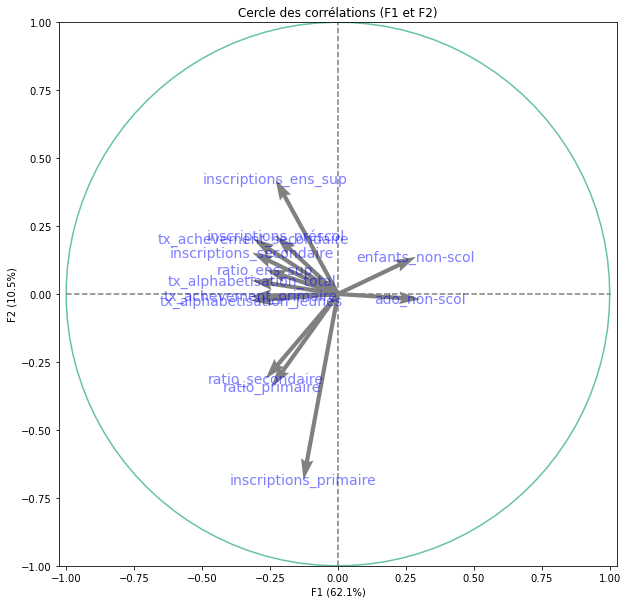

In [36]:
pcs = acp.components_
features = data_acp.columns
display_circles(pcs, p, acp, [(0,1)], labels = np.array(features))

In [37]:
#cosinus carré des variables
cos2var = corvar**2
#print(pd.DataFrame({'id':data_acp.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]}))

In [38]:
#contributions
ctrvar = cos2var
for k in range(p):
  ctrvar[:,k] = ctrvar[:,k]/eigval[k]

#on n'affiche que pour les deux premiers axes
print(pd.DataFrame({'id':data_acp.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]}))

                           id     CTR_1     CTR_2
0                ado_non-scol  0.091364  0.000363
1            enfants_non-scol  0.082405  0.018655
2        inscriptions_ens_sup  0.052804  0.178028
3       inscriptions_primaire  0.016089  0.468397
4        inscriptions_préscol  0.052277  0.045740
5     inscriptions_secondaire  0.099472  0.023138
6               ratio_ens_sup  0.071479  0.008125
7              ratio_primaire  0.059367  0.115696
8            ratio_secondaire  0.070684  0.097343
9      tx_achevement_primaire  0.104102  0.000078
10   tx_achevement_secondaire  0.096989  0.041397
11  tx_alphabetisation_jeunes  0.102550  0.000617
12   tx_alphabetisation_total  0.100418  0.002422


F1 : Adolescents non scolarisés, Enfants non scolarisés, Inscriptions en préscolaire, Ratio femmes/hommes des inscriptions dans l’enseignement supérieur, Inscriptions à l’école secondaire, Taux d'achèvement au primaire, Taux d'achèvement en secondaire, Taux d'alphabétisation des jeunes et de la population adulte

F2 : Accession à l'enseignement secondaire, Inscriptions en cycle supérieur, Inscriptions à l’école primaire, Ratio filles/garçons des inscriptions au primaire, Ratio filles/garçons des inscriptions au secondaire

## Conclusion

L'état des lieux de l'accès à l'éducation est quelque chose de complexe qui nécessite de prendre en compte le nombre d'inscriptions dans les différents cycles scolaires, les taux d'achèvement mais aussi les ratio filles/garçons ainsi que le taux d'alphabétisation. On remarque que les pays où le taux d'alphabétisation est faible ont aussi de faibles pourcentages d'inscription dans les différents et de faibles ratio femmes/hommes.

In [39]:
df_edu2.columns = ['pays','code_pays', 
                   'ados_non-scol', 
                   'enfants_non-scol', 'inscriptions_ens_sup', 
                   'inscriptions_primaire', 'inscriptions_préscol', 
                   'inscriptions_secondaire', 'ratio_ens_sup', 
                   'ratio_primaire', 'ratio_secondaire', 
                   'tx_achevement_primaire', 'tx_achevement_secondaire', 
                   'tx_alphabétisation_jeunes', 'tx_alphabétisation_total']

cols_num = ['ados_non-scol', 
            'enfants_non-scol', 'inscriptions_ens_sup', 
            'inscriptions_primaire', 'inscriptions_préscol', 
            'inscriptions_secondaire', 'ratio_ens_sup', 
            'ratio_primaire', 'ratio_secondaire', 
            'tx_achevement_primaire', 'tx_achevement_secondaire', 
            'tx_alphabétisation_jeunes', 'tx_alphabétisation_total']

# Remplacement des valeurs nulles par la médiane
df_edu2[cols_num] = df_edu2[cols_num].fillna(df_edu2[cols_num].median())

df_edu2.to_csv('df_edu_clean.csv')
df_edu2.to_excel('df_edu_clean.xlsx')

In [40]:
df_edu2.head()

,pays,code_pays,ados_non-scol,enfants_non-scol,inscriptions_ens_sup,inscriptions_primaire,inscriptions_préscol,inscriptions_secondaire,ratio_ens_sup,ratio_primaire,ratio_secondaire,tx_achevement_primaire,tx_achevement_secondaire,tx_alphabétisation_jeunes,tx_alphabétisation_total
0,Afghanistan,AFG,7.781353,3.996940,4.619342,94.895554,3.080470,39.700971,0.294833,0.599088,0.442298,83.511772,43.786143,56.205299,37.234284
1,Afrique du Sud,ZAF,13.785806,7.176252,20.994972,104.268580,22.914647,94.457259,1.296527,0.963646,1.068906,90.047670,80.105780,98.176697,92.109441
2,Albanie,ALB,4.755447,6.472873,41.650427,100.335247,66.300319,86.715374,1.308677,1.016700,0.982993,96.282486,92.401003,99.123790,97.377008
3,Algérie,DZA,7.781353,2.718592,29.798487,111.345440,35.694609,80.699898,1.299649,0.938633,1.063733,98.099923,71.474606,93.277674,74.766516
4,Allemagne,DEU,2.639915,2.280481,67.467917,102.896194,108.693307,101.335926,0.985777,0.995832,0.959991,100.295240,82.629459,98.002903,91.785003


Pour comprendre cette situation, il peut être intéressant de se pencher sur la situation économique de nos 204 pays. 

# Etat des lieux de la situation économique

In [41]:
# Chargement des données
df_eco = pd.read_csv('data_eco.csv', sep=';', encoding='utf-8')

df_eco.drop('Unnamed: 0', axis=1, inplace=True)
df_eco = df_eco.apply(lambda x: x.str.replace(',','.'))

cols = df_eco.columns.to_list()
cols.pop(0)
cols.pop(0)

for i in cols:
    df_eco[i] = df_eco[i].astype('float')

df_eco.head()

,Pays,Code ISO,Capacité (+)/besoin (-) de financement (% du PIB),Chômage (% de la population active) (estimation nationale),Croissance du PIB (% annuel),Croissance du PIB par habitant (% annuel),Croissance du RNB (% annuel),Croissance du RNB par habitant (% annuel),Créances sur le gouvernement central (% du PIB),Dépenses (% du PIB),...,Population âgée de 0 à 14 ans (% du total),RNB ($ US courants),"Taux d emploi, 15 ans et plus (%) (estimation nationale)",Taux d’activité des 15-24 ans (%) (estimation nationale),Total de dette extérieure (% du RNB),Total des réserves (% de la dette extérieure totale),Valeur actuelle de la dette extérieure (% du RNB),Épargne brute (% du PIB),Épargne brute (% du RNB),Épargne intérieure brute (% du PIB)
0,Afghanistan,AFG,-0.461142,5.817500,6.664775,3.452640,NaN,NaN,-6.868596,41.615336,...,46.730536,1.843331e+10,49.372499,45.339999,0.198377,258.877744,2.479109,NaN,NaN,NaN
1,Afrique du Sud,ZAF,-3.156518,27.014737,2.558669,1.144181,2.514491,1.100648,22.192152,31.469927,...,30.210918,2.891640e+11,38.091579,27.254737,3.422221,36.339358,5.570765,16.371788,16.807039,19.719900
2,Albanie,ALB,-3.236472,14.582632,4.117023,4.555113,2.668352,2.954737,31.548796,23.664798,...,22.720388,1.078690e+10,47.963571,34.666428,3.415912,51.868798,8.258809,21.311708,21.014951,9.391536
3,Algérie,DZA,NaN,14.311176,3.252632,1.493450,3.323473,1.563445,-9.840237,NaN,...,29.146231,1.425052e+11,34.886250,25.401429,2.775051,1846.814195,0.283073,47.290134,48.225100,45.964392
4,Allemagne,DEU,-0.606787,6.815263,1.266693,1.210430,1.490509,1.446956,3.221730,29.304015,...,13.942774,3.335235e+12,55.450000,50.402631,NaN,NaN,NaN,26.247102,25.842292,26.142249


In [42]:
df_eco.shape

(217, 30)

In [43]:
df_eco.isnull().mean()

Pays                                                                                    0.000000
Code ISO                                                                                0.000000
Capacité (+)/besoin (-) de financement (% du PIB)                                       0.327189
Chômage (% de la population active) (estimation nationale)                              0.059908
Croissance du PIB (% annuel)                                                            0.036866
Croissance du PIB par habitant (% annuel)                                               0.036866
Croissance du RNB (% annuel)                                                            0.235023
Croissance du RNB par habitant (% annuel)                                               0.235023
Créances sur le gouvernement central (% du PIB)                                         0.147465
Dépenses (% du PIB)                                                                     0.317972
Dépenses publiques en éducatio

## Analyses descriptives

In [44]:
cols = df_eco.columns.to_list()
cols.pop(0)
cols.pop(0)

print(cols)

['Capacité (+)/besoin (-) de financement (% du PIB)', 'Chômage (%\xa0de la population active) (estimation nationale)', 'Croissance du PIB (%\xa0annuel)', 'Croissance du PIB par habitant (%\xa0annuel)', 'Croissance du RNB (% annuel)', 'Croissance du RNB par habitant (% annuel)', 'Créances sur le gouvernement central (% du PIB)', 'Dépenses (%\xa0du PIB)', 'Dépenses publiques en éducation (%\xa0du PIB)', 'Dépenses publiques en éducation, total (%\xa0des dépenses du gouvernement)', 'Indice GINI', 'Inflation, déflateur du PIB (%\xa0annuel)', 'Masse monétaire (% du PIB)', 'PIB ($\xa0US courants)', 'PIB par habitant ($\xa0US courants)', 'Part des revenus détenus par les 20%\xa0moins élevés', 'Part des revenus détenus par les 20%\xa0plus élevés', 'Population active avec un niveau d’études de base (%\xa0de la population active totale)', 'Population âgée de 0 à 14 ans (%\xa0du total)', 'RNB ($\xa0US courants)', 'Taux d emploi, 15\xa0ans et plus (%) (estimation nationale)', 'Taux d’activité des 1

### Analyses univariées

#### Distribution des variables

Capacité (+)/besoin (-) de financement (% du pib)


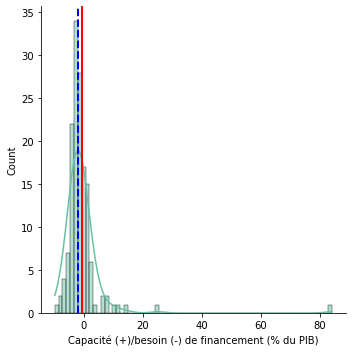

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.33440552995391704, pvalue=5.551115123125783e-16)

Chômage (% de la population active) (estimation nationale)


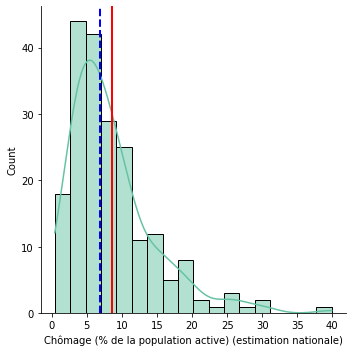

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.1075668202764977, pvalue=0.02959123814759812)

Croissance du pib (% annuel)


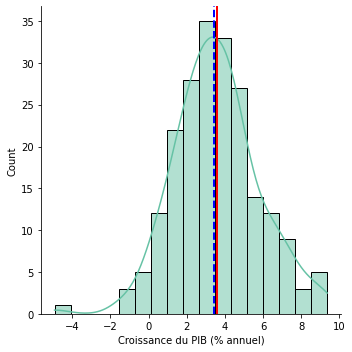

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.061682027649769586, pvalue=0.48408422055537703)

Croissance du pib par habitant (% annuel)


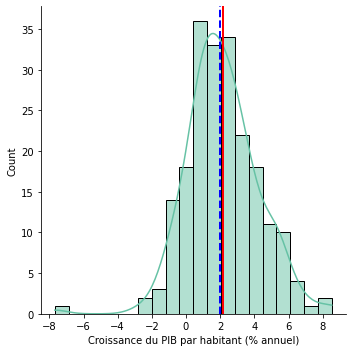

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.07166820276497696, pvalue=0.30216510425736187)

Croissance du rnb (% annuel)


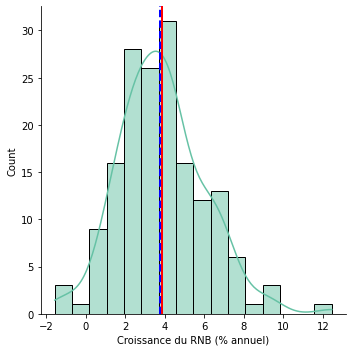

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.2504562211981567, pvalue=2.4866719794403025e-10)

Croissance du rnb par habitant (% annuel)


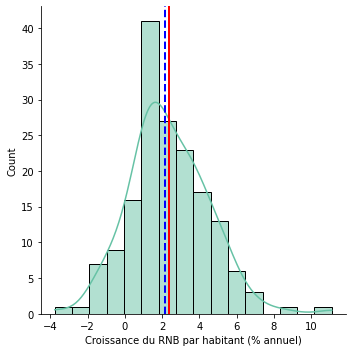

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.24223963133640553, pvalue=1.0955085727459846e-09)

Créances sur le gouvernement central (% du pib)


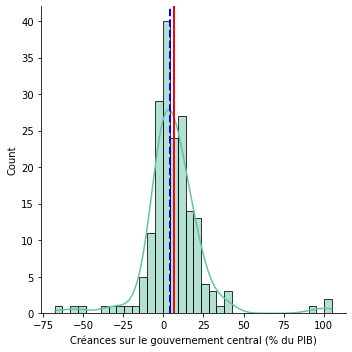

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.1697926267281106, pvalue=5.7510663113991e-05)

Dépenses (% du pib)


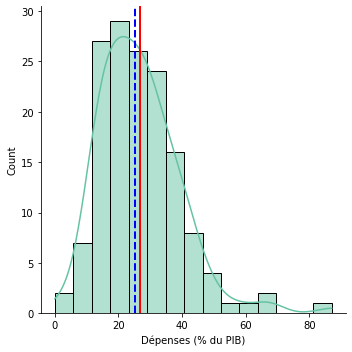

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.33240552995391703, pvalue=5.551115123125783e-16)

Dépenses publiques en éducation (% du pib)


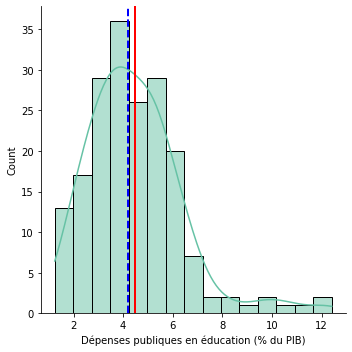

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.15829032258064515, pvalue=0.00022581194924065073)

Dépenses publiques en éducation, total (% des dépenses du gouvernement)


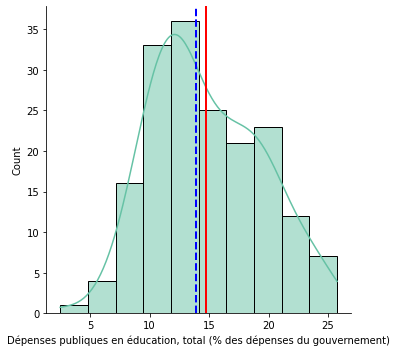

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.19367281105990783, pvalue=2.4681816400695666e-06)

Indice gini


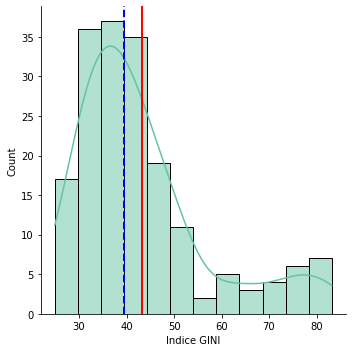

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.2154147465437788, pvalue=9.70080880069446e-08)

Inflation, déflateur du pib (% annuel)


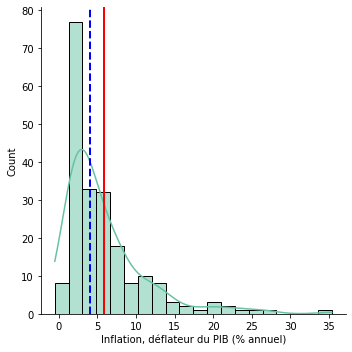

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.1715668202764977, pvalue=4.6151979044339875e-05)

Masse monétaire (% du pib)


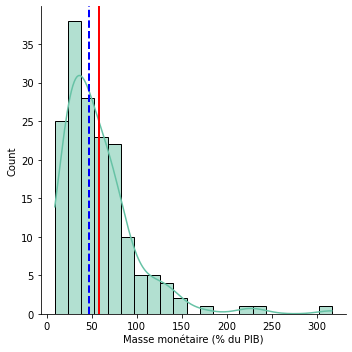

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.2488479262672811, pvalue=3.3376734709378297e-10)

Pib ($ us courants)


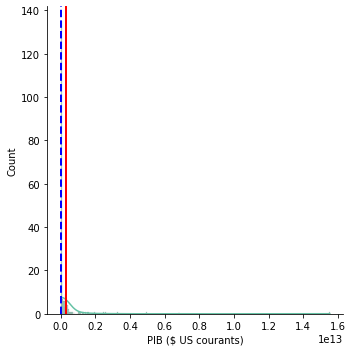

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.409, pvalue=5.551115123125783e-16)

Pib par habitant ($ us courants)


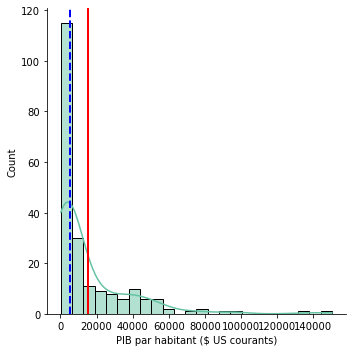

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.264, pvalue=1.9201973344706857e-11)

Part des revenus détenus par les 20% moins élevés


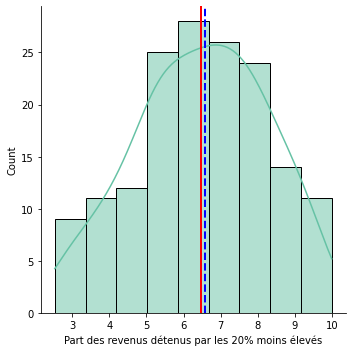

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.2626728110599078, pvalue=2.49172904531747e-11)

Part des revenus détenus par les 20% plus élevés


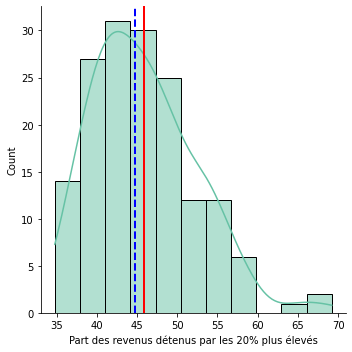

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.27453917050691246, pvalue=2.387534614456399e-12)

Population active avec un niveau d’études de base (% de la population active totale)


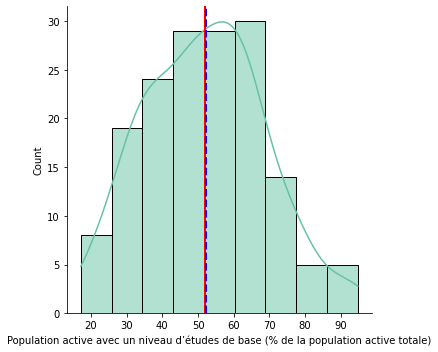

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.25988940092165896, pvalue=4.251121676901448e-11)

Population âgée de 0 à 14 ans (% du total)


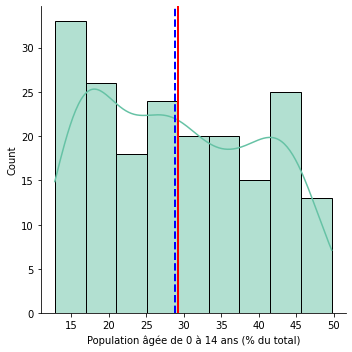

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.1687557603686636, pvalue=6.535938621488047e-05)

Rnb ($ us courants)


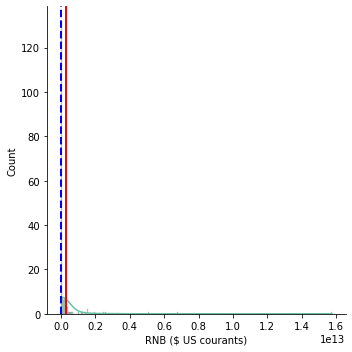

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.401, pvalue=5.551115123125783e-16)

Taux d emploi, 15 ans et plus (%) (estimation nationale)


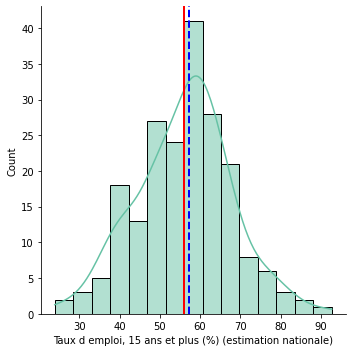

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.10551152073732718, pvalue=0.034682301795997295)

Taux d’activité des 15-24 ans (%) (estimation nationale)


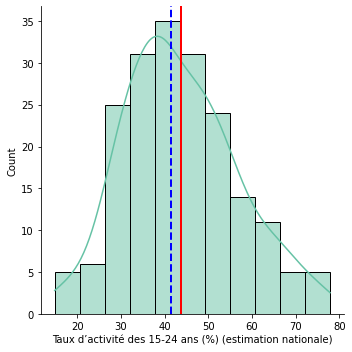

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.14515668202764978, pvalue=0.0009552558950474133)

Total de dette extérieure (% du rnb)


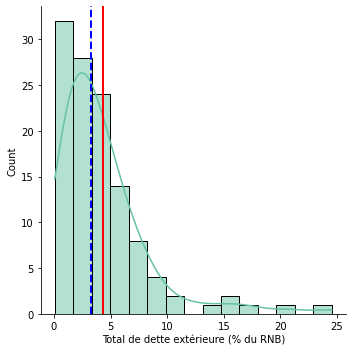

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.4752626728110599, pvalue=5.551115123125783e-16)

Total des réserves (% de la dette extérieure totale)


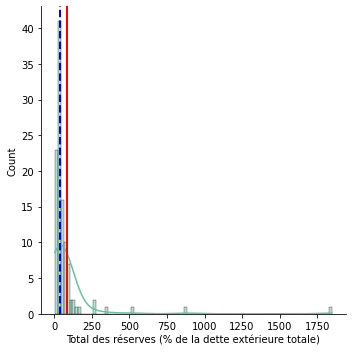

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.5069124423963134, pvalue=5.551115123125783e-16)

Valeur actuelle de la dette extérieure (% du rnb)


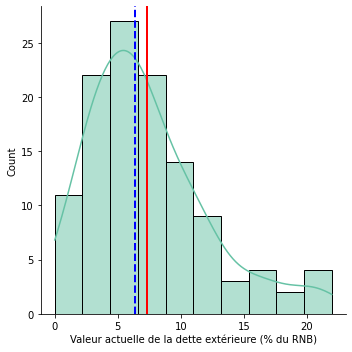

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.47365437788018433, pvalue=5.551115123125783e-16)

Épargne brute (% du pib)


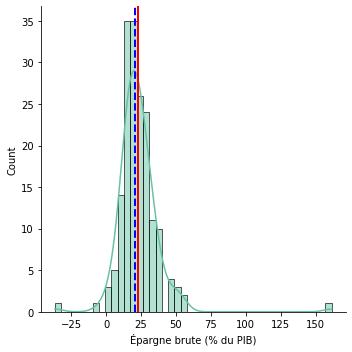

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.19815668202764977, pvalue=1.3032239097876541e-06)

Épargne brute (% du rnb)


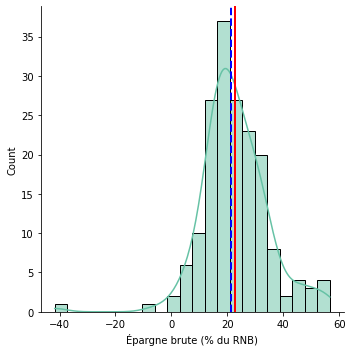

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.2109815668202765, pvalue=1.931297481938543e-07)

Épargne intérieure brute (% du pib)


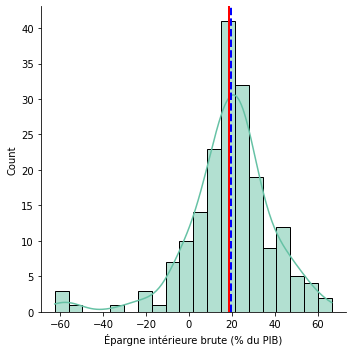

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.14120276497695852, pvalue=0.001439333743692095)



In [45]:
for elt in cols:
    distrib_normalize(df_eco, elt)

Trois de nos variables suivent la loi normale, il s'agit de la croissance du PIB, de la croissance du PIB par habitant et du taux d'emploi des 15 ans et plus. Pour les autres variables, l'analyse des graphiques ainsi que des tests de Kolmogorov-Smirnoff ne permettent pas de dire que nos distributions suivent la loi normale. En revanche notre échantillon étant composée de 217 pays, on peut considérer que nos variables suivent la loi normale.  

#### Statistiques descriptives des variables

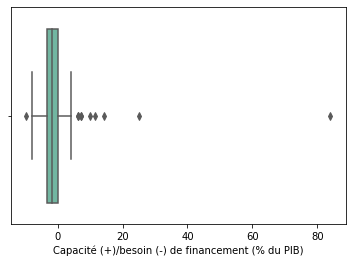

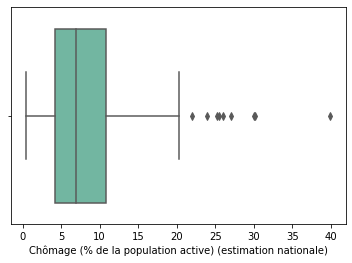

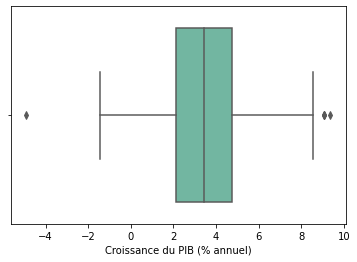

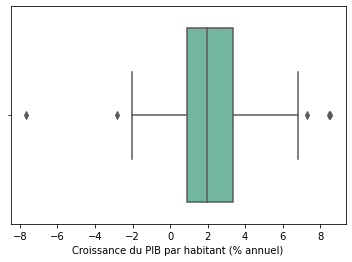

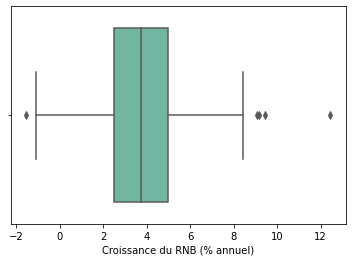

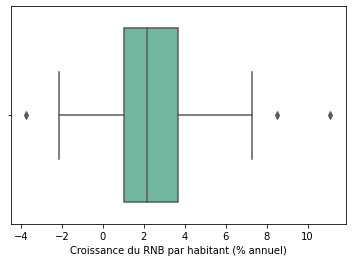

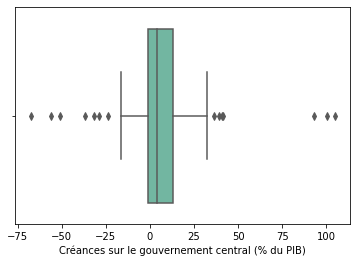

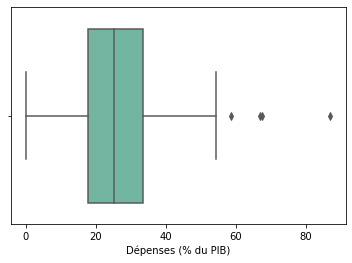

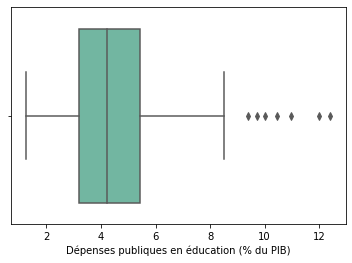

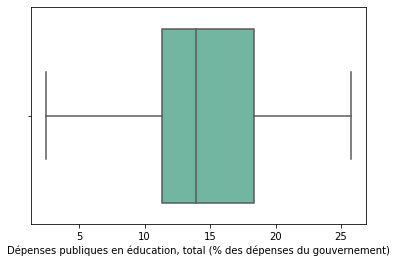

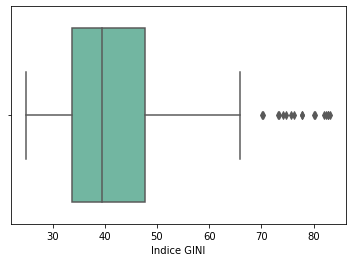

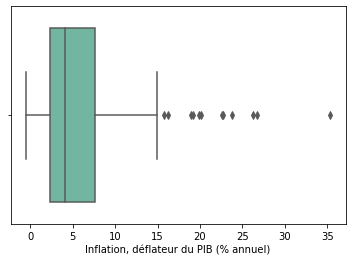

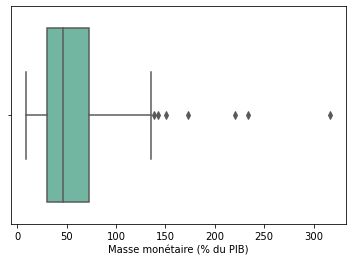

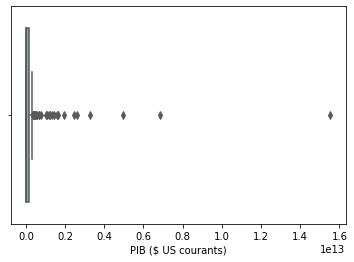

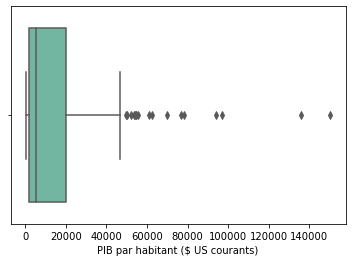

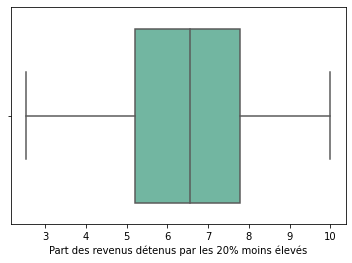

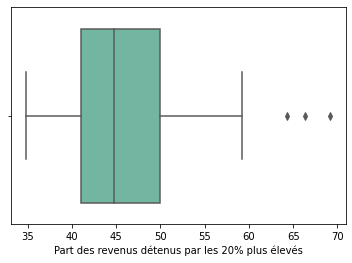

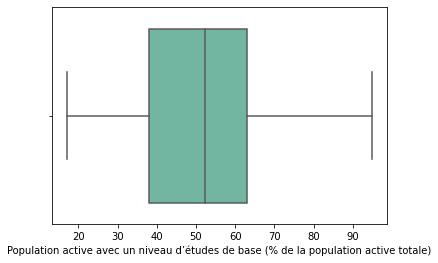

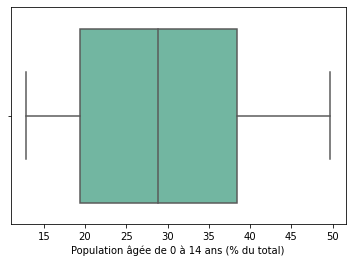

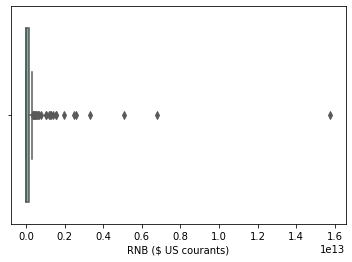

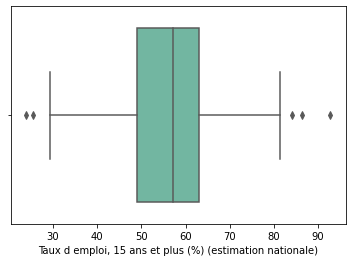

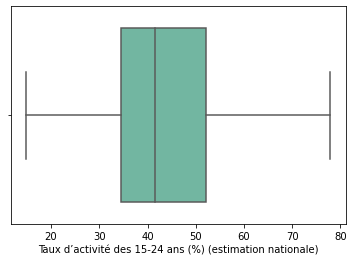

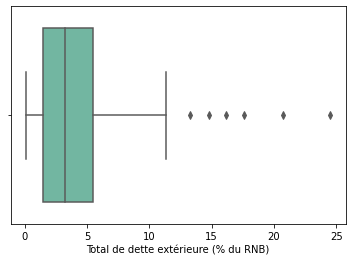

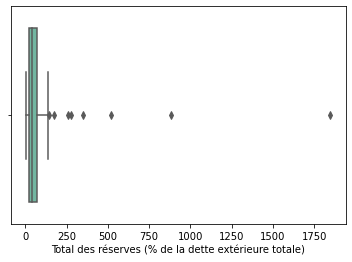

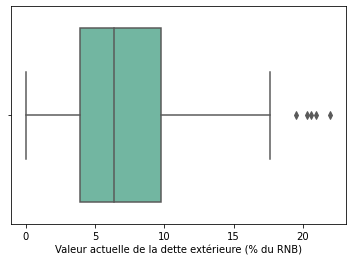

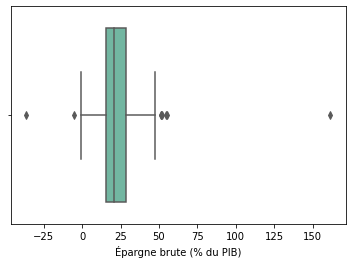

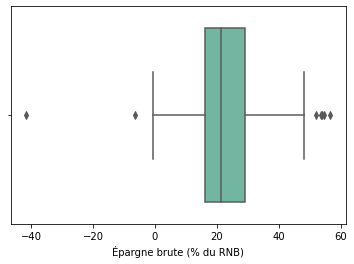

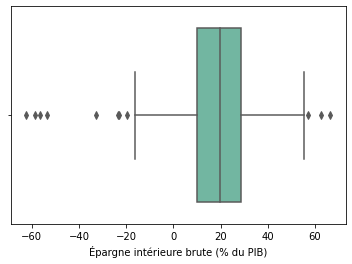

In [46]:
for elt in cols:
    sns.boxplot(x=elt, data=df_eco)
    plt.show()

In [47]:
df_eco.mean().T

Capacité (+)/besoin (-) de financement (% du PIB)                                      -5.647118e-01
Chômage (% de la population active) (estimation nationale)                              8.589983e+00
Croissance du PIB (% annuel)                                                            3.575818e+00
Croissance du PIB par habitant (% annuel)                                               2.137154e+00
Croissance du RNB (% annuel)                                                            3.856968e+00
Croissance du RNB par habitant (% annuel)                                               2.363818e+00
Créances sur le gouvernement central (% du PIB)                                         6.354388e+00
Dépenses (% du PIB)                                                                     2.666204e+01
Dépenses publiques en éducation (% du PIB)                                              4.482390e+00
Dépenses publiques en éducation, total (% des dépenses du gouvernement)                 1.4

In [48]:
df_eco.median().T

Capacité (+)/besoin (-) de financement (% du PIB)                                      -1.840846e+00
Chômage (% de la population active) (estimation nationale)                              6.880263e+00
Croissance du PIB (% annuel)                                                            3.454174e+00
Croissance du PIB par habitant (% annuel)                                               1.983123e+00
Croissance du RNB (% annuel)                                                            3.740233e+00
Croissance du RNB par habitant (% annuel)                                               2.168450e+00
Créances sur le gouvernement central (% du PIB)                                         3.968033e+00
Dépenses (% du PIB)                                                                     2.520033e+01
Dépenses publiques en éducation (% du PIB)                                              4.212266e+00
Dépenses publiques en éducation, total (% des dépenses du gouvernement)                 1.3

In [49]:
df_eco.to_csv('df_eco.csv')
df_eco.to_excel('df_eco.xlsx')

In [50]:
df_eco2 = df_eco.copy()
df_eco2.columns = ['pays', 'code_pays', 'cap_financement', 
                   'chômage total', 'croissance_PIB', 'croissance_PIB_hab', 
                   'croissance_RNB', 'croissance_RNB_hab', 'creances_gouv_central', 
                   'depenses', 'depenses_pub_educ', 'depenses_pub_educ_total', 'Indice GINI', 
                   'inflateur', 'masse_monetaire', 'PIB', 'PIB_hab', 'part_revenus_20prc_moins', 'part_revenus_20prc_plus', 
                   'pop_active_avc_niveau_diplom', 'pop_0-14', 'RNB', 'tx_emploi_15+', 
                   'tx_emploi_15-24', 'tot_dette_exterieur', 'tot_reserves', 'val_dette_exterieur', 
                   'epargne_brut_PIB', 'epargne_brut_RNB', 'epargne_interieure_brut']

### Analyses bivariées

#### Matrice de corrélation

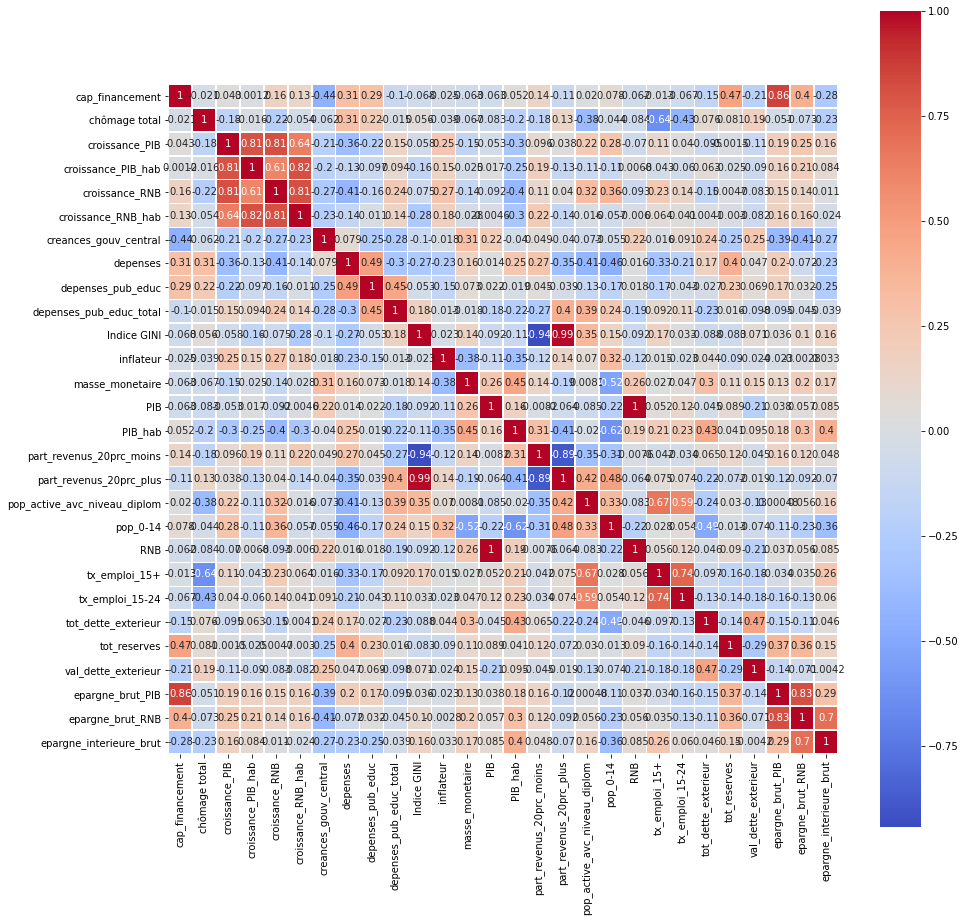

In [51]:
corrMatrix = df_eco2.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

In [52]:
# On enlève les variables qui n'ont aucune corrélation avec les autres
# De plus, le RNB et le PIB étant fortement corrélée (1), on supprime le RNB pour éviter la redondance dans nos variables
df_eco2.drop(['croissance_RNB', 'croissance_RNB_hab', 'creances_gouv_central', 'depenses', 'depenses_pub_educ', 'depenses_pub_educ_total', 'inflateur', 
              'masse_monetaire', 'PIB', 'PIB_hab', 'pop_0-14', 'RNB', 'tot_dette_exterieur', 'tot_reserves', 'val_dette_exterieur', 'epargne_brut_RNB'], axis=1, inplace=True)

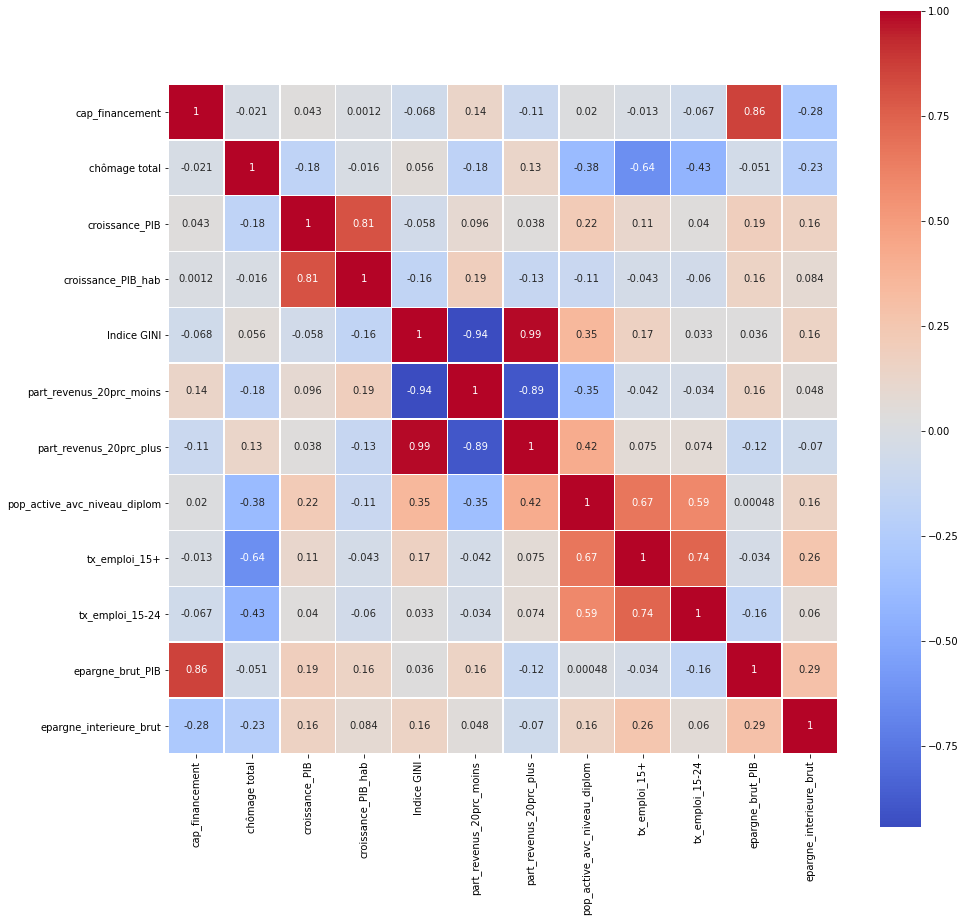

In [53]:
corrMatrix = df_eco2.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

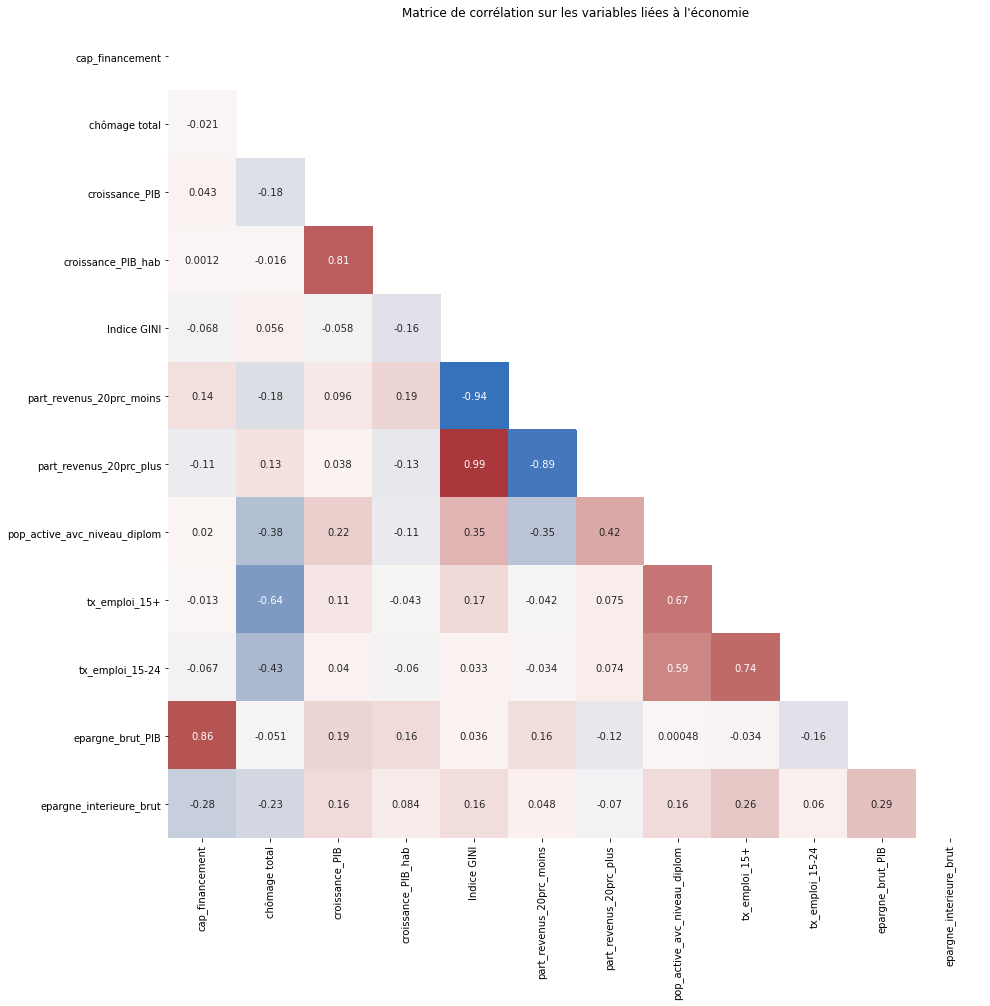

In [54]:
mask = np.triu(corrMatrix)

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, mask = mask, fmt = '.2g', annot=True, vmin=-1, vmax=1, cmap='vlag', center= 0, cbar=False)
plt.title('Matrice de corrélation sur les variables liées à l\'économie')
plt.savefig('Corr_matrix_economie.png')
plt.show()

In [55]:
# On enlève les variables qui n'ont aucune corrélation avec les autres
# De plus, le RNB et le PIB étant fortement corrélée (1), on supprime le RNB pour éviter la redondance dans nos variables
df_eco2.drop(['part_revenus_20prc_moins','part_revenus_20prc_plus', 'epargne_interieure_brut'], axis=1, inplace=True)

### Analyse en composante principale

In [56]:
# Préprocessing des data
# On n'a au préalable supprimer les variables qui n'avaient aucune corrélation avec les autres
data_acp2 = df_eco2.set_index('pays')
data_acp2.drop('code_pays', axis=1, inplace = True)

print(data_acp2.shape)
n = data_acp2.shape[0]
p = data_acp2.shape[1]

(217, 9)


In [57]:
# Remplacement des valeurs nulles par la médiane
data_acp2[data_acp2.columns] = data_acp2[data_acp2.columns].apply(pd.to_numeric, errors='coerce')
data_acp2 = data_acp2.fillna(data_acp2.median())

# Normalisation des valeurs
sc = StandardScaler()
Z = sc.fit_transform(data_acp2)

In [58]:
acp2 = PCA()
print(acp2)

PCA()


In [59]:
coord = acp2.fit_transform(Z)
print(acp2.n_components_)

9


In [60]:
# Correction de la variance expliquée
eigval = (n-1)/n*acp2.explained_variance_
print(eigval)

[2.69834297 1.99184745 1.56196219 1.0840038  0.63071567 0.42006476
 0.2622542  0.21013273 0.14067623]


In [61]:
# proportion de valeurs expliquées
ratio = acp2.explained_variance_ratio_ * 100
print(acp2.explained_variance_ratio_)

[0.29981589 0.22131638 0.17355135 0.12044487 0.07007952 0.04667386
 0.02913936 0.02334808 0.01563069]


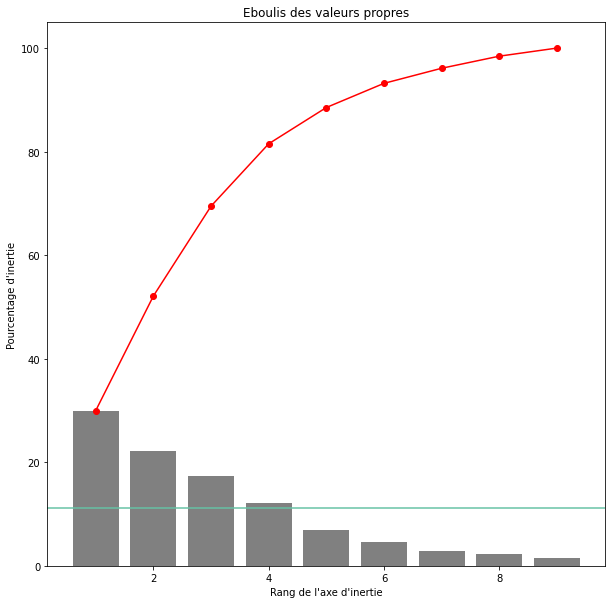

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
scree = acp2.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.axhline(y=100/p)
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Selon le critère de Kaiser, les composantes expliquant plus de 8.33% de la variance peuvent être sélectionnés. Les composantes F1, F2, F3, et F4 seront donc observées. 

In [63]:
# contribution des individus dans l'inertie totale
di = np.sum(Z**2,axis=1)
print(pd.DataFrame({'ID':data_acp2.index,'d_i':di}).sort_values('d_i', ascending=False))

                                    ID         d_i
186                        Timor-Leste  267.431067
95                              Kosovo   46.604457
176                      Soudan du Sud   43.593218
148                              Qatar   30.908281
54                            Djibouti   30.313731
..                                 ...         ...
174                            Somalie    0.209190
47   Corée. République démocratique de    0.204020
67                           Gibraltar    0.204020
162                  Saint-Martin (fr)    0.204020
216          Îles Vierges britanniques    0.204020

[217 rows x 2 columns]


In [64]:
# qualité de représentation des individus - COS2
cos2 = coord**2

for j in range(p):
  cos2[:,j] = cos2[:,j]/di

qualite = pd.DataFrame({'id':data_acp2.index,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1], 'COS2_F3':cos2[:,2],'COS2_F4':cos2[:,3]})

print(qualite)

                            id   COS2_F1   COS2_F2   COS2_F3   COS2_F4
0                  Afghanistan  0.009609  0.143378  0.080977  0.422513
1               Afrique du Sud  0.514667  0.070871  0.000300  0.339882
2                      Albanie  0.463667  0.113554  0.244930  0.013376
3                      Algérie  0.511837  0.049813  0.059050  0.008522
4                    Allemagne  0.029737  0.103113  0.106383  0.552178
..                         ...       ...       ...       ...       ...
212              Îles Marshall  0.459743  0.071230  0.175071  0.000547
213               Îles Salomon  0.750213  0.066389  0.000699  0.003655
214    Îles Turques-et-Caïques  0.223587  0.077070  0.129772  0.030697
215          Îles Vierges (EU)  0.005373  0.609454  0.270661  0.060467
216  Îles Vierges britanniques  0.022180  0.070473  0.047227  0.405364

[217 rows x 5 columns]


In [65]:
print(qualite.sort_values('COS2_F1', ascending=False).head(10))

             id   COS2_F1   COS2_F2   COS2_F3   COS2_F4
147       Pérou  0.879413  0.027385  0.014917  0.007925
140    Paraguay  0.864359  0.001560  0.016713  0.049035
183    Tanzanie  0.849032  0.060380  0.014987  0.005061
23      Bolivie  0.846491  0.000182  0.023516  0.067511
106  Madagascar  0.842735  0.063588  0.009719  0.000752
35     Cameroun  0.837210  0.019846  0.003093  0.007153
32        Bénin  0.799927  0.010783  0.003802  0.000155
204    Équateur  0.795161  0.011263  0.031622  0.043005
187        Togo  0.781946  0.050620  0.000022  0.001964
122  Mozambique  0.774558  0.043356  0.118218  0.014135


In [66]:
print(qualite.sort_values('COS2_F2', ascending=False).head(10))

                                                 id   COS2_F1   COS2_F2  \
135                                     Ouzbékistan  0.021200  0.903367   
14                                      Azerbaïdjan  0.004923  0.867807   
9                                         Argentine  0.098797  0.857993   
152  Région administrative spéciale de Macao. Chine  0.125111  0.786054   
89                                         Jamaïque  0.103902  0.735837   
176                                   Soudan du Sud  0.009402  0.715869   
17                                       Bangladesh  0.079635  0.688060   
120                                        Mongolie  0.003258  0.660550   
146                                        Portugal  0.018242  0.654124   
38                                            Chine  0.149443  0.644717   

      COS2_F3   COS2_F4  
135  0.015466  0.040726  
14   0.049943  0.021481  
9    0.000254  0.031059  
152  0.070398  0.000095  
89   0.047442  0.029591  
176  0.218601  0.0

In [67]:
print(qualite.sort_values('COS2_F3', ascending=False).head(10))

                               id   COS2_F1   COS2_F2   COS2_F3   COS2_F4
44           Congo. République du  0.031653  0.016053  0.667549  0.085406
186                   Timor-Leste  0.015888  0.384898  0.578673  0.005373
117  Micronésie. États fédérés de  0.037243  0.174366  0.571243  0.019966
151                        Rwanda  0.049070  0.279809  0.500572  0.099431
129                       Norvège  0.138157  0.011607  0.487957  0.309006
109                      Maldives  0.002341  0.037639  0.467570  0.016647
170                  Sierra Leone  0.021012  0.017990  0.433987  0.068868
94                       Kiribati  0.315846  0.049550  0.432705  0.001728
21                       Bermudes  0.028908  0.124548  0.424382  0.046267
29                   Burkina Faso  0.268301  0.031806  0.420786  0.060871


In [68]:
print(qualite.sort_values('COS2_F4', ascending=False).head(10))

                          id   COS2_F1   COS2_F2   COS2_F3   COS2_F4
76                    Guyane  0.001291  0.062736  0.013447  0.677328
55                 Dominique  0.003360  0.148036  0.048674  0.648310
180                    Suède  0.070572  0.012040  0.139817  0.633710
179                 Suriname  0.004303  0.010628  0.153338  0.630658
25                  Botswana  0.090436  0.037963  0.033866  0.618461
124                  Namibie  0.258388  0.015136  0.001257  0.614724
173                 Slovénie  0.254110  0.002198  0.003734  0.595106
68                   Grenade  0.000396  0.042552  0.006440  0.591195
20                    Belize  0.061695  0.235855  0.001733  0.576769
39   Chine. RAS de Hong Kong  0.021007  0.000203  0.017976  0.555406


In [69]:
# contribution aux axes
ctr = coord**2
for j in range(p):
  ctr[:,j] = ctr[:,j]/(n*eigval[j]) # eigval = c. 40 (variance expliquée et corrigé)

contribution = pd.DataFrame({'id':data_acp2.index,'CTR_F1':ctr[:,0],'CTR_F2':ctr[:,1], 'CTR_F3':ctr[:,2],'CTR_F4':ctr[:,3]})
print(contribution)

                            id    CTR_F1    CTR_F2    CTR_F3    CTR_F4
0                  Afghanistan  0.000104  0.002095  0.001509  0.011342
1               Afrique du Sud  0.015516  0.002894  0.000016  0.025506
2                      Albanie  0.003586  0.001190  0.003273  0.000258
3                      Algérie  0.009829  0.001296  0.001959  0.000407
4                    Allemagne  0.000182  0.000854  0.001123  0.008403
..                         ...       ...       ...       ...       ...
212              Îles Marshall  0.003983  0.000836  0.002620  0.000012
213               Îles Salomon  0.025000  0.002997  0.000040  0.000303
214    Îles Turques-et-Caïques  0.000493  0.000230  0.000494  0.000168
215          Îles Vierges (EU)  0.000077  0.011890  0.006734  0.002168
216  Îles Vierges britanniques  0.000008  0.000033  0.000028  0.000352

[217 rows x 5 columns]


In [70]:
print(contribution.sort_values('CTR_F1', ascending=False).head(10))

                     id    CTR_F1    CTR_F2    CTR_F3        CTR_F4
95               Kosovo  0.056228  0.002326  0.007487  2.108366e-03
54             Djibouti  0.035876  0.009578  0.007024  8.226866e-03
148               Qatar  0.033815  0.006774  0.001598  5.542739e-05
106          Madagascar  0.033283  0.003402  0.000663  7.389126e-05
34             Cambodge  0.032573  0.004720  0.004699  1.606228e-02
207            Éthiopie  0.027073  0.014506  0.007546  8.783736e-04
213        Îles Salomon  0.025000  0.002997  0.000040  3.031911e-04
183            Tanzanie  0.023455  0.002260  0.000715  3.480061e-04
24   Bosnie-Herzégovine  0.023098  0.000014  0.003800  3.576853e-07
105   Macédoine du Nord  0.020010  0.000122  0.000377  1.909189e-03


In [71]:
print(contribution.sort_values('CTR_F2', ascending=False).head(10))

                                                 id    CTR_F1    CTR_F2  \
186                                     Timor-Leste  0.007257  0.238145   
176                                   Soudan du Sud  0.000700  0.072200   
152  Région administrative spéciale de Macao. Chine  0.003945  0.033578   
38                                            Chine  0.005701  0.033318   
14                                      Azerbaïdjan  0.000136  0.032366   
123                                         Myanmar  0.005539  0.026859   
101                                         Libéria  0.005981  0.021526   
201                                        Zimbabwe  0.005099  0.017864   
207                                        Éthiopie  0.027073  0.014506   
18                                          Barbade  0.000709  0.014500   

       CTR_F3    CTR_F4  
186  0.456578  0.006108  
176  0.028115  0.002386  
152  0.003835  0.000007  
38   0.006716  0.000026  
14   0.002375  0.001472  
123  0.015403  0.0

In [72]:
print(contribution.sort_values('CTR_F3', ascending=False).head(10))

                       id    CTR_F1    CTR_F2    CTR_F3    CTR_F4
186           Timor-Leste  0.007257  0.238145  0.456578  0.006108
94               Kiribati  0.013948  0.002964  0.033011  0.000190
176         Soudan du Sud  0.000700  0.072200  0.028115  0.002386
26      Brunéi Darussalam  0.000193  0.001114  0.018952  0.026457
123               Myanmar  0.005539  0.026859  0.015403  0.000196
129               Norvège  0.002451  0.000279  0.014952  0.013644
44   Congo. République du  0.000401  0.000275  0.014605  0.002692
10                Arménie  0.005834  0.007732  0.013907  0.000023
182           Tadjikistan  0.003313  0.007867  0.013300  0.002999
161           Saint-Marin  0.013195  0.005719  0.011654  0.000098


In [73]:
print(contribution.sort_values('CTR_F4', ascending=False).head(10))

                     id    CTR_F1    CTR_F2    CTR_F3    CTR_F4
68              Grenade  0.000013  0.001947  0.000376  0.049713
179            Suriname  0.000117  0.000392  0.007210  0.042726
171           Singapour  0.007400  0.005072  0.007413  0.038612
100               Libye  0.010186  0.008293  0.000544  0.035343
55            Dominique  0.000065  0.003875  0.001625  0.031187
15              Bahamas  0.000348  0.007005  0.005378  0.029625
20               Belize  0.001151  0.005960  0.000056  0.026783
26    Brunéi Darussalam  0.000193  0.001114  0.018952  0.026457
1        Afrique du Sud  0.015516  0.002894  0.000016  0.025506
74   Guinée équatoriale  0.000700  0.005717  0.002104  0.025307


In [74]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
  corvar[:,k] = acp2.components_[k,:] * sqrt_eigval[k]

In [75]:
#on affiche pour les quatre premiers axes
print(pd.DataFrame({'id':data_acp2.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1], 'COR_3':corvar[:,2],'COR_4':corvar[:,3]}))

                             id     COR_1     COR_2     COR_3     COR_4
0               cap_financement  0.038975  0.537747  0.749486 -0.078305
1                 chômage total  0.708739 -0.103602 -0.040160  0.332328
2                croissance_PIB -0.208112  0.782188 -0.491344  0.154116
3            croissance_PIB_hab  0.005929  0.776534 -0.553685  0.059030
4                   Indice GINI -0.179392 -0.158119  0.126353  0.909632
5  pop_active_avc_niveau_diplom -0.779679 -0.019891  0.097093  0.286958
6                 tx_emploi_15+ -0.914431 -0.028693  0.062346 -0.064700
7               tx_emploi_15-24 -0.819045 -0.120151 -0.017439 -0.150364
8              epargne_brut_PIB  0.063765  0.660653  0.648885  0.060192


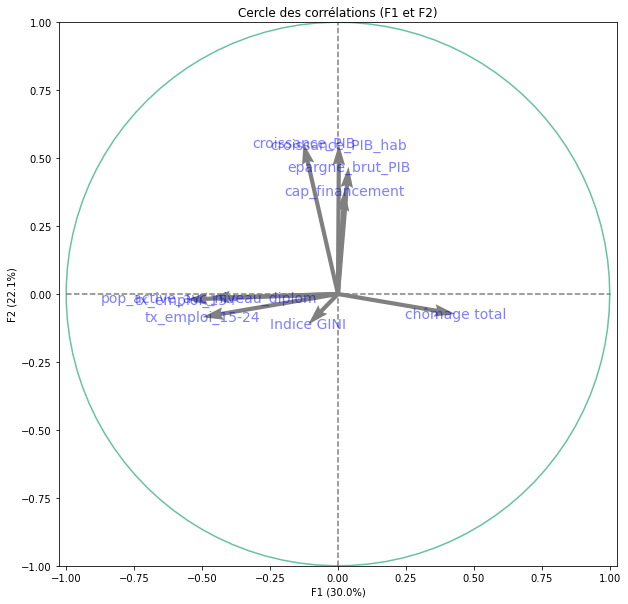

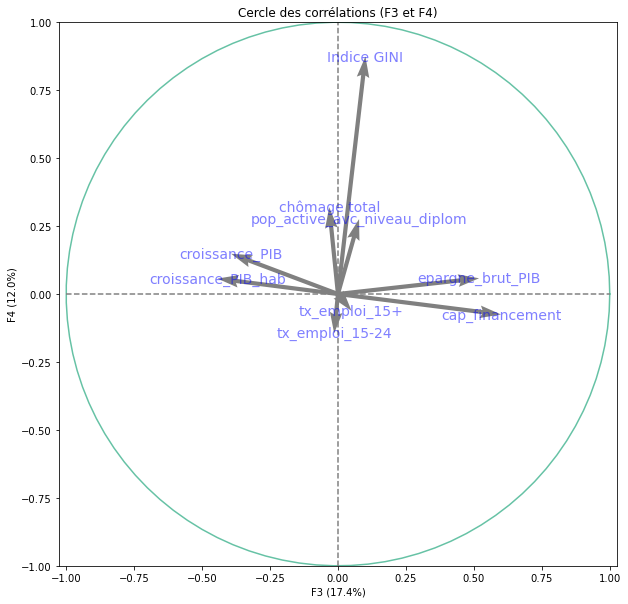

In [76]:
pcs2 = acp2.components_
features = data_acp2.columns
display_circles(pcs2, p, acp2, [(0,1), (2,3)], labels = np.array(features))

In [77]:
#cosinus carré des variables
cos2var = corvar**2
#print(pd.DataFrame({'id':data_acp2.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1], 'COS2_3':cos2var[:,2],'COS2_4':cos2var[:,3], 'COS2_5':cos2var[:,4],'COS2_6':cos2var[:,5]}))

In [78]:
#contributions
ctrvar = cos2var
for k in range(p):
  ctrvar[:,k] = ctrvar[:,k]/eigval[k]

#on n'affiche que pour les six premiers axes
print(pd.DataFrame({'id':data_acp2.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1], 'CTR_3':ctrvar[:,2],'CTR_4':ctrvar[:,3]}))

                             id     CTR_1     CTR_2     CTR_3     CTR_4
0               cap_financement  0.000563  0.145177  0.359631  0.005656
1                 chômage total  0.186155  0.005389  0.001033  0.101883
2                croissance_PIB  0.016051  0.307161  0.154561  0.021911
3            croissance_PIB_hab  0.000013  0.302737  0.196270  0.003215
4                   Indice GINI  0.011926  0.012552  0.010221  0.763309
5  pop_active_avc_niveau_diplom  0.225286  0.000199  0.006035  0.075964
6                 tx_emploi_15+  0.309888  0.000413  0.002489  0.003862
7               tx_emploi_15-24  0.248610  0.007248  0.000195  0.020857
8              epargne_brut_PIB  0.001507  0.219124  0.269566  0.003342


- F1 : Indice de GINI, Revenus détenus par les 20% les moins élevés, Revenus détenus par les 20% les plus élevés, Population active avec diplôme de base, Population de 0 à 14 ans 
- F2 : Chômage total, PIB par habitant,Taux d'emploi des 15 ans et plus, Taux d'actifs des 15-24 ans,  Epargne intérieure brute
- F3 : Croissance PIB, Croissance PIB par habitant, 
- F4 : Capacité/Besoin de financement, Epargne brute (PIB)

## Conclusion

In [79]:
df_eco2.columns = ['pays', 'code_pays', 'capacite_financement', 'chomage_total', 'croissance_pib', 'croissance_pib_hab', 'indice_gini', 'pop_active_avec_diplome', 'tx_emploi_15+', 'tx_actifs_15-24', 'epargne_brute(PIB)']

cols_num2 = ['capacite_financement', 'chomage_total', 'croissance_pib', 'croissance_pib_hab', 'indice_gini', 'pop_active_avec_diplome', 'tx_emploi_15+', 'tx_actifs_15-24', 'epargne_brute(PIB)']

# Remplacement des valeurs nulles par la médiane
df_eco2[cols_num2] = df_eco2[cols_num2].fillna(df_eco2[cols_num2].median())                   
                   
df_eco2.to_csv('df_eco_clean.csv')
df_eco2.to_excel('df_eco_clean.xlsx')

In [80]:
df_eco2.head()

,pays,code_pays,capacite_financement,chomage_total,croissance_pib,croissance_pib_hab,indice_gini,pop_active_avec_diplome,tx_emploi_15+,tx_actifs_15-24,epargne_brute(PIB)
0,Afghanistan,AFG,-0.461142,5.817500,6.664775,3.452640,65.500000,49.745001,49.372499,45.339999,20.896559
1,Afrique du Sud,ZAF,-3.156518,27.014737,2.558669,1.144181,63.550000,43.265556,38.091579,27.254737,16.371788
2,Albanie,ALB,-3.236472,14.582632,4.117023,4.555113,31.962500,45.808462,47.963571,34.666428,21.311708
3,Algérie,DZA,-1.840846,14.311176,3.252632,1.493450,27.600000,52.174000,34.886250,25.401429,47.290134
4,Allemagne,DEU,-0.606787,6.815263,1.266693,1.210430,30.878571,38.054737,55.450000,50.402631,26.247102


# Corrélation entre situation économique et éducation

In [81]:
df = pd.merge(df_edu2, df_eco2, on=['pays', 'code_pays']).reset_index()
df.drop('index', axis=1, inplace=True)
df.head()

,pays,code_pays,ados_non-scol,enfants_non-scol,inscriptions_ens_sup,inscriptions_primaire,inscriptions_préscol,inscriptions_secondaire,ratio_ens_sup,ratio_primaire,...,tx_alphabétisation_total,capacite_financement,chomage_total,croissance_pib,croissance_pib_hab,indice_gini,pop_active_avec_diplome,tx_emploi_15+,tx_actifs_15-24,epargne_brute(PIB)
0,Afghanistan,AFG,7.781353,3.996940,4.619342,94.895554,3.080470,39.700971,0.294833,0.599088,...,37.234284,-0.461142,5.817500,6.664775,3.452640,65.500000,49.745001,49.372499,45.339999,20.896559
1,Afrique du Sud,ZAF,13.785806,7.176252,20.994972,104.268580,22.914647,94.457259,1.296527,0.963646,...,92.109441,-3.156518,27.014737,2.558669,1.144181,63.550000,43.265556,38.091579,27.254737,16.371788
2,Albanie,ALB,4.755447,6.472873,41.650427,100.335247,66.300319,86.715374,1.308677,1.016700,...,97.377008,-3.236472,14.582632,4.117023,4.555113,31.962500,45.808462,47.963571,34.666428,21.311708
3,Algérie,DZA,7.781353,2.718592,29.798487,111.345440,35.694609,80.699898,1.299649,0.938633,...,74.766516,-1.840846,14.311176,3.252632,1.493450,27.600000,52.174000,34.886250,25.401429,47.290134
4,Allemagne,DEU,2.639915,2.280481,67.467917,102.896194,108.693307,101.335926,0.985777,0.995832,...,91.785003,-0.606787,6.815263,1.266693,1.210430,30.878571,38.054737,55.450000,50.402631,26.247102


In [82]:
del df_edu
del df_edu2
del df_eco
del df_eco2

In [83]:
df.to_csv('df_final.csv')
df.to_excel('df_final.xlsx')

## Matrice de corrélation

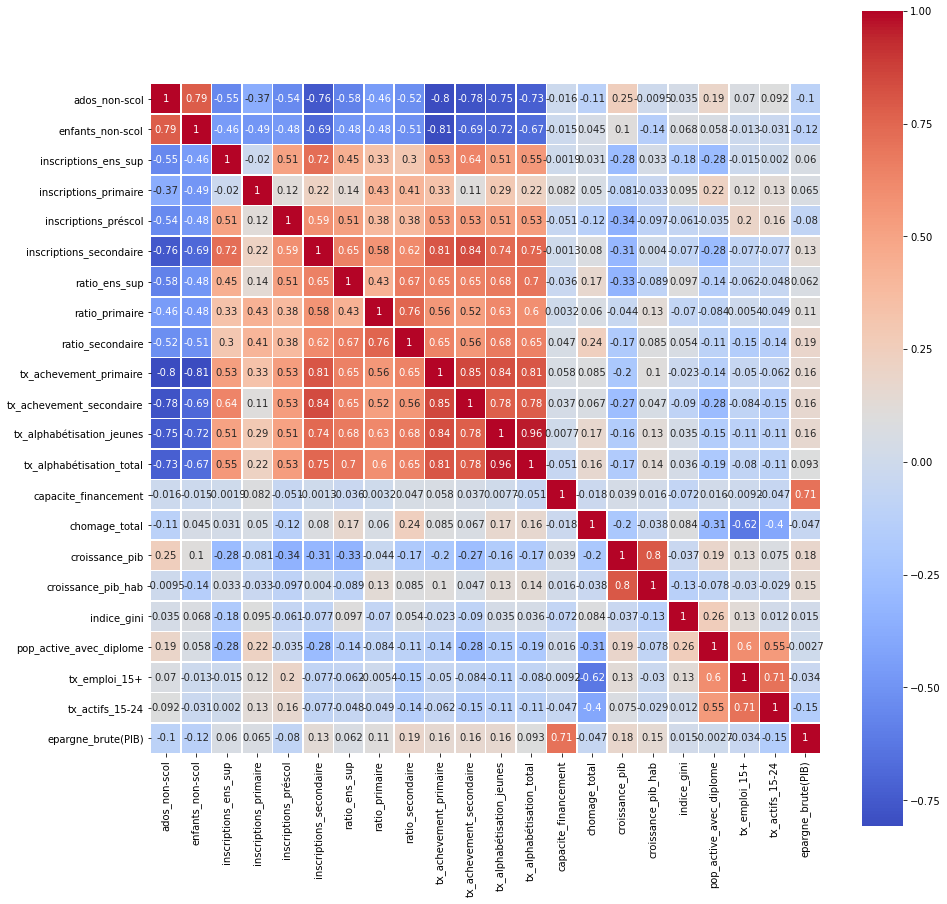

In [84]:
corrMatrix = df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

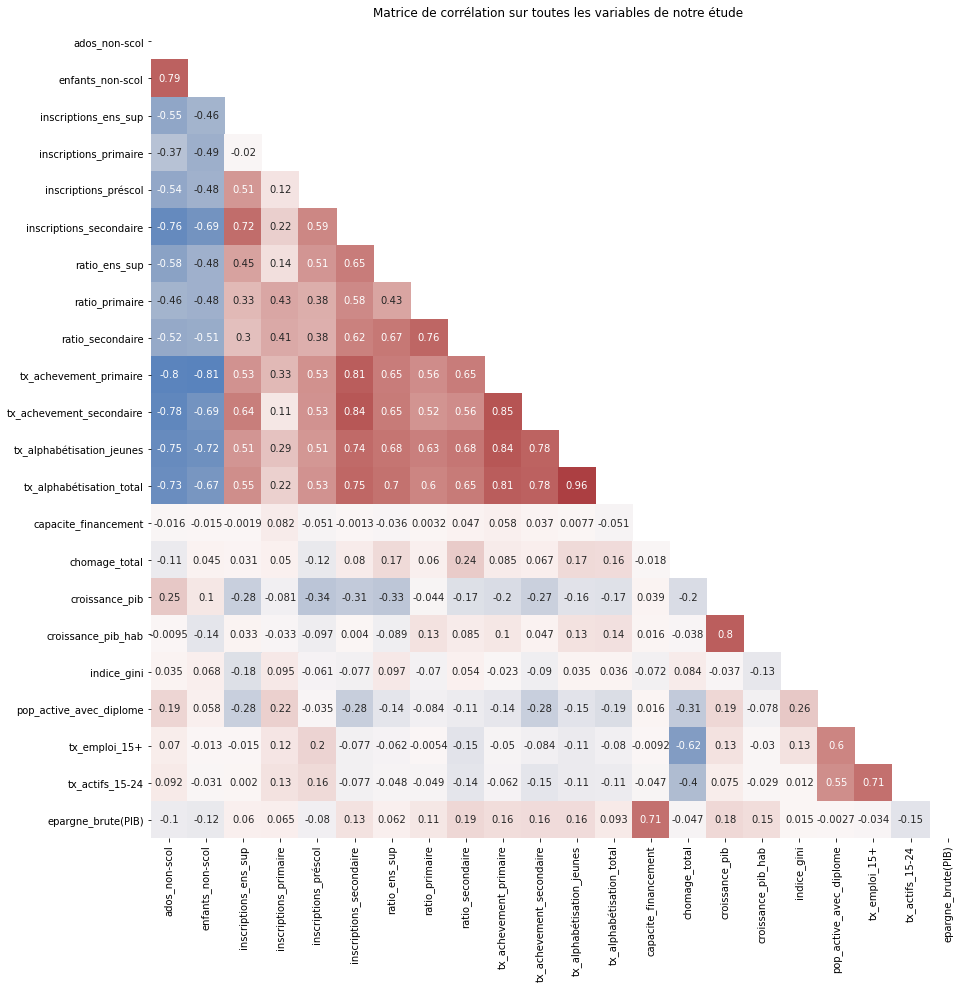

In [85]:
mask = np.triu(corrMatrix)

plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, square=True, mask = mask, fmt = '.2g', annot=True, vmin=-1, vmax=1, cmap='vlag', center= 0, cbar=False)
plt.title('Matrice de corrélation sur toutes les variables de notre étude')
plt.savefig('Corr_Matrix_total.png')
plt.show()

## Analyses en composantes principales

In [86]:
data_acp3 = df.set_index('pays')
data_acp3.drop('code_pays', axis=1, inplace = True)

print(data_acp3.shape)
n = data_acp3.shape[0]
p = data_acp3.shape[1]

(204, 22)


In [87]:
sc = StandardScaler()
Z = sc.fit_transform(data_acp3)

In [88]:
acp3 = PCA()
coord = acp3.fit_transform(Z)
print(acp3.n_components_)

22


In [89]:
#valeur corrigée
eigval = (n-1)/n*acp3.explained_variance_
print(eigval)

[8.2565781  2.74732541 2.12887474 1.61751662 1.52704087 1.03382463
 0.80999638 0.63180215 0.52202045 0.45656244 0.38401507 0.33745511
 0.28318486 0.23906481 0.23289413 0.18390196 0.15127616 0.14307393
 0.11523101 0.09461264 0.07445913 0.02928939]


In [90]:
# proportion de valeurs expliquées
ratio = acp3.explained_variance_ratio_ * 100
print(acp3.explained_variance_ratio_)

[0.375299   0.12487843 0.09676703 0.07352348 0.06941095 0.04699203
 0.03681802 0.02871828 0.0237282  0.02075284 0.01745523 0.01533887
 0.01287204 0.01086658 0.0105861  0.00835918 0.00687619 0.00650336
 0.00523777 0.00430057 0.00338451 0.00133134]


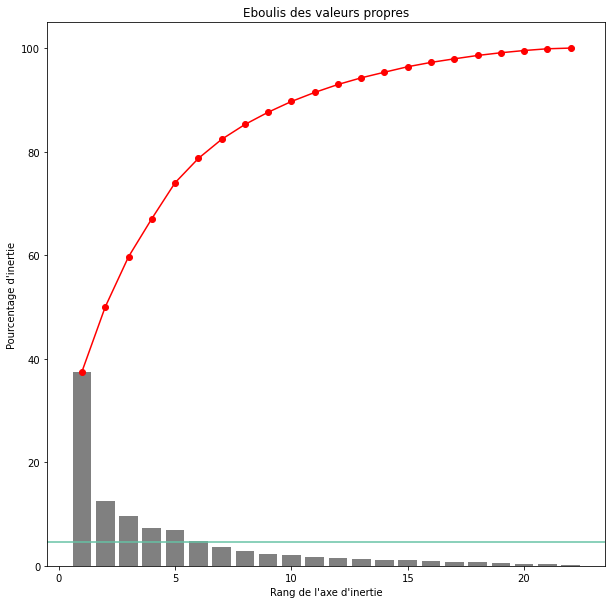

In [91]:
fig, ax = plt.subplots(figsize=(10,10))
scree = acp3.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.axhline(y=100/p)
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Selon le critère de Kaiser, il est intéressant de conserver les composantes qui expliquent plus de 3,7% de la variance. Les composantes F1, F2, F3, F4, F5 et F6 seront donc conservées. 

In [92]:
# contribution des individus dans l'inertie totale
di = np.sum(Z**2,axis=1)
print(pd.DataFrame({'ID':data_acp3.index,'d_i':di}))

                            ID        d_i
0                  Afghanistan  71.796504
1               Afrique du Sud  21.660325
2                      Albanie   7.850750
3                      Algérie  13.991438
4                    Allemagne  10.325779
..                         ...        ...
199                 Îles Féroé   2.136743
200              Îles Marshall   9.463732
201               Îles Salomon  23.907057
202    Îles Turques-et-Caïques   9.297339
203  Îles Vierges britanniques   5.950754

[204 rows x 2 columns]


In [93]:
# qualité de représentation des individus - COS2
cos2 = coord**2

for j in range(p):
  cos2[:,j] = cos2[:,j]/di

qualite = pd.DataFrame({'id':data_acp3.index,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1], 'COS2_F3':cos2[:,2], 'COS2_F4':cos2[:,3], 'COS2_F5':cos2[:,4], 'COS2_F6':cos2[:,5]})

print(qualite)

                            id   COS2_F1   COS2_F2   COS2_F3   COS2_F4  \
0                  Afghanistan  0.479649  0.001889  0.002712  0.008734   
1               Afrique du Sud  0.042466  0.461296  0.020104  0.131148   
2                      Albanie  0.378130  0.219882  0.056121  0.119680   
3                      Algérie  0.043730  0.360649  0.053593  0.097884   
4                    Allemagne  0.409477  0.000751  0.094656  0.048633   
..                         ...       ...       ...       ...       ...   
199                 Îles Féroé  0.450746  0.051846  0.007843  0.006079   
200              Îles Marshall  0.043319  0.288447  0.013200  0.155087   
201               Îles Salomon  0.063780  0.620777  0.067175  0.000798   
202    Îles Turques-et-Caïques  0.000745  0.013461  0.000024  0.040426   
203  Îles Vierges britanniques  0.597241  0.027397  0.034052  0.004823   

      COS2_F5   COS2_F6  
0    0.009362  0.023450  
1    0.184950  0.049169  
2    0.042943  0.001301  
3    0.

In [94]:
print(qualite.sort_values('COS2_F1', ascending=False).head(10))

                            id   COS2_F1   COS2_F2   COS2_F3   COS2_F4  \
51               Côte d'Ivoire  0.921874  0.000279  0.012949  0.002934   
106                       Mali  0.918226  0.001300  0.003654  0.013707   
174                      Tchad  0.914406  0.001534  0.001427  0.023725   
121                      Niger  0.890069  0.005505  0.003517  0.014877   
28                Burkina Faso  0.886814  0.001698  0.000128  0.021384   
146  République centrafricaine  0.877904  0.018174  0.042878  0.000788   
70                      Guinée  0.872204  0.008082  0.012491  0.041482   
171                    Sénégal  0.742375  0.047038  0.000016  0.004917   
116                 Mozambique  0.737279  0.168924  0.004049  0.005970   
197                   Éthiopie  0.727640  0.108665  0.054854  0.043995   

      COS2_F5       COS2_F6  
51   0.015465  1.990436e-03  
106  0.016184  4.869974e-04  
174  0.017854  2.149872e-03  
121  0.025660  1.181356e-02  
28   0.001822  7.381744e-04  
146  

In [95]:
print(qualite.sort_values('COS2_F2', ascending=False).head(10))

                                id   COS2_F1   COS2_F2   COS2_F3   COS2_F4  \
139                          Pérou  0.106594  0.778717  0.020323  0.011772   
88                        Jordanie  0.000643  0.700156  0.000848  0.014073   
40             Cisjordanie et Gaza  0.093749  0.656086  0.000040  0.009281   
201                   Îles Salomon  0.063780  0.620777  0.067175  0.000798   
23              Bosnie-Herzégovine  0.095220  0.598987  0.006696  0.003013   
22                         Bolivie  0.139226  0.579140  0.003212  0.000788   
101              Macédoine du Nord  0.069700  0.566900  0.000031  0.001607   
188                       Viet Nam  0.023774  0.560540  0.235596  0.059334   
192    Égypte. République arabe d’  0.000314  0.507363  0.001037  0.111170   
80   Iran. République islamique d’  0.122133  0.506347  0.000100  0.039725   

      COS2_F5   COS2_F6  
139  0.005860  0.005190  
88   0.019360  0.002220  
40   0.079622  0.001061  
201  0.004284  0.002268  
23   0.0892

In [96]:
print(qualite.sort_values('COS2_F3', ascending=False).head(10))

                                                 id   COS2_F1   COS2_F2  \
13                                      Azerbaïdjan  0.022818  0.000778   
128                                     Ouzbékistan  0.027169  0.005322   
37                                            Chine  0.028507  0.141114   
144  Région administrative spéciale de Macao. Chine  0.038930  0.115108   
78                                             Inde  0.052837  0.000225   
117                                         Myanmar  0.173569  0.069756   
21                                          Bhoutan  0.299903  0.018053   
86                                         Jamaïque  0.132547  0.060909   
79                                        Indonésie  0.011917  0.257221   
181                                    Turkménistan  0.013327  0.054407   

      COS2_F3   COS2_F4   COS2_F5   COS2_F6  
13   0.741179  0.088110  0.000539  0.004879  
128  0.608259  0.047906  0.002434  0.000582  
37   0.551862  0.136738  0.003601  0

In [97]:
print(qualite.sort_values('COS2_F4', ascending=False).head(10))

                               id   COS2_F1   COS2_F2   COS2_F3   COS2_F4  \
169                      Suriname  0.016382  0.003969  0.013551  0.377603   
112  Micronésie. États fédérés de  0.050439  0.050261  0.074088  0.362588   
63                          Gabon  0.004149  0.173343  0.009812  0.343297   
118                       Namibie  0.001076  0.160667  0.003181  0.333574   
25              Brunéi Darussalam  0.221133  0.009278  0.014062  0.325174   
141                      Roumanie  0.372103  0.109480  0.054416  0.322160   
50                        Curacao  0.143159  0.007928  0.077869  0.283164   
24                       Botswana  0.037018  0.083236  0.083938  0.272189   
91                       Kiribati  0.193015  0.189661  0.054099  0.270503   
172                   Tadjikistan  0.000207  0.107999  0.259746  0.265430   

      COS2_F5   COS2_F6  
169  0.069977  0.185705  
112  0.051042  0.010747  
63   0.033243  0.177014  
118  0.418238  0.008589  
25   0.005857  0.19974

In [98]:
print(qualite.sort_values('COS2_F5', ascending=False).head(10))

                       id   COS2_F1   COS2_F2   COS2_F3   COS2_F4   COS2_F5  \
123               Norvège  0.354409  0.106852  0.003329  0.000427  0.468320   
118               Namibie  0.001076  0.160667  0.003181  0.333574  0.418238   
176           Timor-Leste  0.001343  0.010920  0.337139  0.264925  0.364038   
143                Rwanda  0.232709  0.023258  0.168775  0.012894  0.333024   
157  Sao Tomé-et-Principe  0.040812  0.246603  0.040593  0.093829  0.279282   
41               Colombie  0.308958  0.171374  0.000207  0.049631  0.245775   
19                 Belize  0.035310  0.045186  0.098836  0.211356  0.239728   
12               Autriche  0.420295  0.015178  0.097460  0.082746  0.231035   
168                Suisse  0.243540  0.244032  0.034754  0.006936  0.223043   
181          Turkménistan  0.013327  0.054407  0.383689  0.025848  0.219218   

      COS2_F6  
123  0.010964  
118  0.008589  
176  0.003021  
143  0.107243  
157  0.060321  
41   0.000045  
19   0.168004  
12

In [99]:
print(qualite.sort_values('COS2_F6', ascending=False).head(10))

                     id   COS2_F1   COS2_F2   COS2_F3   COS2_F4   COS2_F5  \
14              Bahamas  0.004968  0.000341  0.141417  0.190751  0.007815   
179   Trinité-et-Tobago  0.148064  0.039202  0.010491  0.073621  0.079113   
15              Bahreïn  0.204599  0.037944  0.001492  0.140719  0.002177   
73               Guyane  0.087798  0.000093  0.050346  0.054045  0.176857   
54            Dominique  0.150357  0.001017  0.112607  0.177549  0.055461   
71   Guinée équatoriale  0.362285  0.002500  0.022565  0.004839  0.015442   
6    Antigua-et-Barbuda  0.236694  0.080896  0.095646  0.088722  0.051093   
92               Koweït  0.215009  0.046153  0.001112  0.118431  0.009240   
17              Barbade  0.287631  0.017792  0.331518  0.019054  0.022853   
161           Singapour  0.157186  0.137232  0.064684  0.053528  0.014928   

      COS2_F6  
14   0.428520  
179  0.294148  
15   0.293161  
73   0.277530  
54   0.270313  
71   0.253702  
6    0.249020  
92   0.246131  
17   0.2

In [100]:
# contribution aux axes
ctr = coord**2
for j in range(p):
  ctr[:,j] = ctr[:,j]/(n*eigval[j]) # eigval = c. 40 (variance expliquée et corrigé)

contribution = pd.DataFrame({'id':data_acp3.index,'CTR_F1':ctr[:,0],'CTR_F2':ctr[:,1], 'CTR_F3':ctr[:,2],'CTR_F4':ctr[:,3], 'CTR_F5':ctr[:,4],'CTR_F6':ctr[:,5]})
print(contribution)

                            id    CTR_F1    CTR_F2        CTR_F3    CTR_F4  \
0                  Afghanistan  0.020445  0.000242  4.484169e-04  0.001900   
1               Afrique du Sud  0.000546  0.017828  1.002707e-03  0.008609   
2                      Albanie  0.001762  0.003080  1.014510e-03  0.002847   
3                      Algérie  0.000363  0.009003  1.726594e-03  0.004150   
4                    Allemagne  0.002510  0.000014  2.250560e-03  0.001522   
..                         ...       ...       ...           ...       ...   
199                 Îles Féroé  0.000572  0.000198  3.858728e-05  0.000039   
200              Îles Marshall  0.000243  0.004871  2.876450e-04  0.004448   
201               Îles Salomon  0.000905  0.026480  3.697872e-03  0.000058   
202    Îles Turques-et-Caïques  0.000004  0.000223  5.233633e-07  0.001139   
203  Îles Vierges britanniques  0.002110  0.000291  4.665939e-04  0.000087   

       CTR_F5    CTR_F6  
0    0.002158  0.007983  
1    0.0128

In [101]:
print(contribution.sort_values('CTR_F1', ascending=False).head(10))

                            id    CTR_F1    CTR_F2    CTR_F3    CTR_F4  \
121                      Niger  0.056729  0.001055  0.000869  0.004840   
174                      Tchad  0.056575  0.000285  0.000342  0.007493   
146  République centrafricaine  0.047941  0.002983  0.009081  0.000220   
166              Soudan du Sud  0.043564  0.001564  0.107531  0.013619   
70                      Guinée  0.038078  0.001060  0.002115  0.009244   
28                Burkina Faso  0.036708  0.000211  0.000021  0.004518   
106                       Mali  0.034365  0.000146  0.000530  0.002618   
197                   Éthiopie  0.032664  0.014660  0.009550  0.010081   
51               Côte d'Ivoire  0.022124  0.000020  0.001205  0.000359   
0                  Afghanistan  0.020445  0.000242  0.000448  0.001900   

       CTR_F5    CTR_F6  
121  0.008843  0.006013  
174  0.005973  0.001062  
146  0.008907  0.003643  
166  0.031433  0.003235  
70   0.004496  0.000227  
28   0.000408  0.000244  
106

In [102]:
print(contribution.sort_values('CTR_F2', ascending=False).head(10))

                      id    CTR_F1    CTR_F2    CTR_F3    CTR_F4    CTR_F5  \
53              Djibouti  0.011943  0.061331  0.008868  0.003354  0.005256   
140                Qatar  0.000533  0.032572  0.005430  0.000989  0.000657   
102           Madagascar  0.008446  0.032464  0.001356  0.013656  0.005045   
33              Cambodge  0.007414  0.031363  0.008201  0.000020  0.011455   
201         Îles Salomon  0.000905  0.026480  0.003698  0.000058  0.000329   
189       Yémen. Rép. du  0.014063  0.025122  0.013751  0.001485  0.008421   
23    Bosnie-Herzégovine  0.001241  0.023465  0.000339  0.000200  0.006289   
101    Macédoine du Nord  0.000914  0.022337  0.000002  0.000108  0.002598   
83               Islande  0.003101  0.021985  0.002068  0.003092  0.005482   
40   Cisjordanie et Gaza  0.000973  0.020464  0.000002  0.000492  0.004468   

       CTR_F6  
53   0.027474  
140  0.006711  
102  0.013243  
33   0.003817  
201  0.000257  
189  0.001412  
23   0.001473  
101  0.000224

In [103]:
print(contribution.sort_values('CTR_F3', ascending=False).head(10))

                                                 id    CTR_F1    CTR_F2  \
176                                     Timor-Leste  0.000207  0.005047   
166                                   Soudan du Sud  0.043564  0.001564   
97                                          Libéria  0.011391  0.005403   
13                                      Azerbaïdjan  0.000257  0.000026   
37                                            Chine  0.000414  0.006166   
117                                         Myanmar  0.003070  0.003708   
144  Région administrative spéciale de Macao. Chine  0.000495  0.004394   
128                                     Ouzbékistan  0.000196  0.000115   
17                                          Barbade  0.003536  0.000657   
181                                    Turkménistan  0.000138  0.001698   

       CTR_F3    CTR_F4    CTR_F5    CTR_F6  
176  0.201074  0.207956  0.302686  0.003710  
166  0.107531  0.013619  0.031433  0.003235  
97   0.032736  0.003314  0.000253  0

In [104]:
print(contribution.sort_values('CTR_F4', ascending=False).head(10))

                       id    CTR_F1    CTR_F2    CTR_F3    CTR_F4    CTR_F5  \
176           Timor-Leste  0.000207  0.005047  0.201074  0.207956  0.302686   
169              Suriname  0.000256  0.000186  0.000821  0.030124  0.005913   
164               Somalie  0.005516  0.002665  0.004753  0.029923  0.037214   
91               Kiribati  0.003706  0.010945  0.004029  0.026513  0.008232   
50                Curacao  0.002525  0.000420  0.005327  0.025493  0.004971   
63                  Gabon  0.000060  0.007531  0.000550  0.025334  0.002599   
93                Lesotho  0.000081  0.012141  0.000811  0.024947  0.020795   
25      Brunéi Darussalam  0.003074  0.000388  0.000758  0.023074  0.000440   
43   Congo. République du  0.006154  0.001590  0.000045  0.019274  0.001096   
172           Tadjikistan  0.000003  0.003927  0.012189  0.016394  0.001620   

       CTR_F6  
176  0.003710  
169  0.023179  
164  0.096538  
91   0.004395  
50   0.025535  
63   0.020438  
93   0.001885  
25

In [105]:
print(contribution.sort_values('CTR_F5', ascending=False).head(10))

                                                 id    CTR_F1    CTR_F2  \
176                                     Timor-Leste  0.000207  0.005047   
164                                         Somalie  0.005516  0.002665   
166                                   Soudan du Sud  0.043564  0.001564   
123                                         Norvège  0.004131  0.003743   
143                                          Rwanda  0.003511  0.001055   
93                                          Lesotho  0.000081  0.012141   
118                                         Namibie  0.000008  0.003428   
58                                         Eswatini  0.000423  0.014573   
1                                    Afrique du Sud  0.000546  0.017828   
144  Région administrative spéciale de Macao. Chine  0.000495  0.004394   

           CTR_F3    CTR_F4    CTR_F5    CTR_F6  
176  2.010737e-01  0.207956  0.302686  0.003710  
164  4.752870e-03  0.029923  0.037214  0.096538  
166  1.075312e-01  0.013

In [106]:
print(contribution.sort_values('CTR_F6', ascending=False).head(10))

                     id    CTR_F1    CTR_F2    CTR_F3    CTR_F4    CTR_F5  \
164             Somalie  0.005516  0.002665  0.004753  0.029923  0.037214   
71   Guinée équatoriale  0.010598  0.000220  0.002560  0.000723  0.002443   
14              Bahamas  0.000050  0.000010  0.005556  0.009863  0.000428   
161           Singapour  0.002697  0.007075  0.004304  0.004688  0.001385   
104              Malawi  0.004607  0.011874  0.000363  0.004481  0.011896   
53             Djibouti  0.011943  0.061331  0.008868  0.003354  0.005256   
67              Grenade  0.005671  0.000268  0.002771  0.002860  0.001694   
50              Curacao  0.002525  0.000420  0.005327  0.025493  0.004971   
92               Koweït  0.002758  0.001779  0.000055  0.007754  0.000641   
160        Sierra Leone  0.011292  0.000095  0.001249  0.000567  0.003154   

       CTR_F6  
164  0.096538  
71   0.059273  
14   0.034668  
161  0.031671  
104  0.030854  
53   0.027474  
67   0.025558  
50   0.025535  
92   0.0

In [107]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
  corvar[:,k] = acp3.components_[k,:] * sqrt_eigval[k]

#afficher la matrice des corrélations variables x facteurs    
#print(corvar)

In [108]:
#on affiche pour les quatre premiers axes
print(pd.DataFrame({'id':data_acp3.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1], 'COR_3':corvar[:,0],'COR_4':corvar[:,1], 'COR_5':corvar[:,0],'COR_6':corvar[:,1]}))

                           id     COR_1     COR_2     COR_3     COR_4  \
0               ados_non-scol  0.858842  0.037242  0.858842  0.037242   
1            enfants_non-scol  0.802180  0.206446  0.802180  0.206446   
2        inscriptions_ens_sup -0.659427  0.017098 -0.659427  0.017098   
3       inscriptions_primaire -0.343828 -0.303820 -0.343828 -0.303820   
4        inscriptions_préscol -0.637416 -0.281699 -0.637416 -0.281699   
5     inscriptions_secondaire -0.900768  0.005346 -0.900768  0.005346   
6               ratio_ens_sup -0.762639  0.008848 -0.762639  0.008848   
7              ratio_primaire -0.683628 -0.100449 -0.683628 -0.100449   
8            ratio_secondaire -0.758350  0.038694 -0.758350  0.038694   
9      tx_achevement_primaire -0.912205 -0.078503 -0.912205 -0.078503   
10   tx_achevement_secondaire -0.890228  0.041840 -0.890228  0.041840   
11  tx_alphabétisation_jeunes -0.907657 -0.009418 -0.907657 -0.009418   
12   tx_alphabétisation_total -0.898173 -0.001266 -

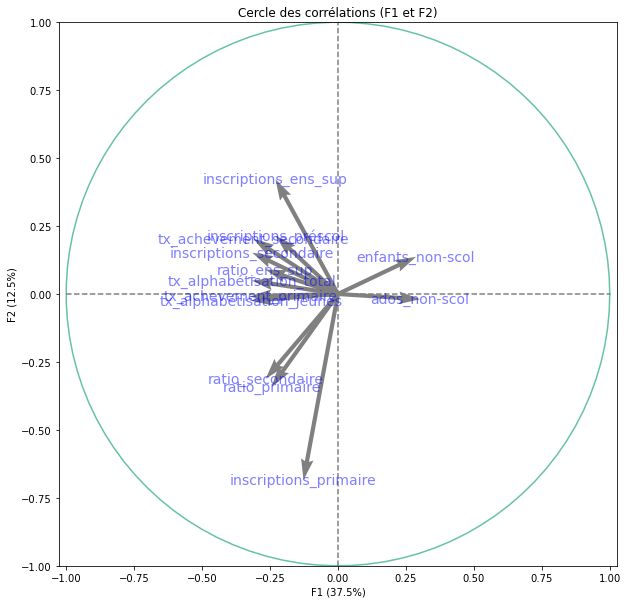

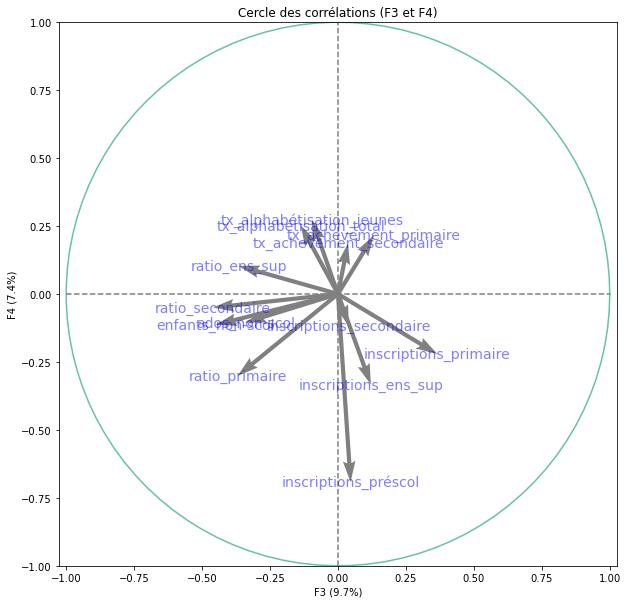

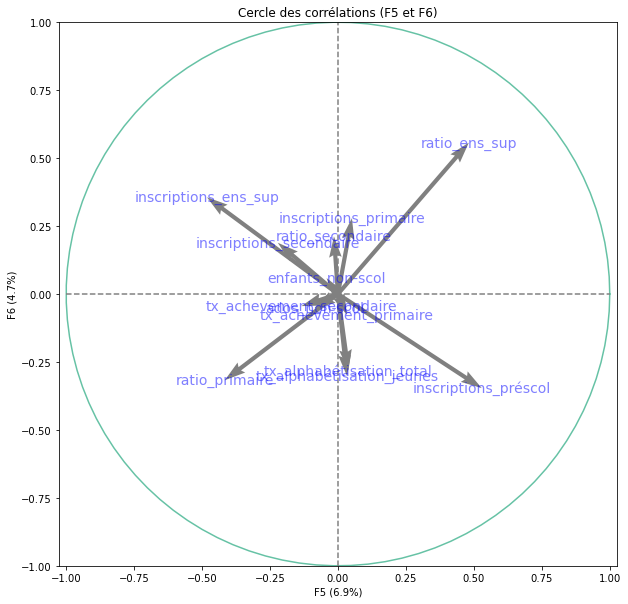

In [109]:
pcs3 = acp3.components_
features = data_acp3.columns
display_circles(pcs, p, acp3, [(0,1), (2,3), (4,5)], labels = np.array(features))

In [110]:
#cosinus carré des variables
cos2var = corvar**2
#print(pd.DataFrame({'id':data_acp3.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1], COS2_3':cos2var[:,2],'COS2_4':cos2var[:,3], COS2_5':cos2var[:,4],'COS2_6':cos2var[:,5]}))

In [111]:
#contributions
ctrvar = cos2var
for k in range(p):
  ctrvar[:,k] = ctrvar[:,k]/eigval[k]

#on n'affiche que pour les six premiers axes
print(pd.DataFrame({'id':data_acp3.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1], 'CTR_3':ctrvar[:,2],'CTR_4':ctrvar[:,3], 'CTR_5':ctrvar[:,4],'CTR_6':ctrvar[:,5]}))

                           id     CTR_1         CTR_2     CTR_3     CTR_4  \
0               ados_non-scol  0.089336  5.048522e-04  0.000269  0.000043   
1            enfants_non-scol  0.077937  1.551321e-02  0.007446  0.000542   
2        inscriptions_ens_sup  0.052666  1.064098e-04  0.009371  0.064810   
3       inscriptions_primaire  0.014318  3.359864e-02  0.006929  0.139151   
4        inscriptions_préscol  0.049209  2.888427e-02  0.041499  0.014711   
5     inscriptions_secondaire  0.098271  1.040452e-05  0.002203  0.006543   
6               ratio_ens_sup  0.070443  2.849573e-05  0.013975  0.005752   
7              ratio_primaire  0.056603  3.672691e-03  0.015773  0.004523   
8            ratio_secondaire  0.069653  5.449767e-04  0.008562  0.042665   
9      tx_achevement_primaire  0.100782  2.243199e-03  0.003027  0.000007   
10   tx_achevement_secondaire  0.095985  6.371921e-04  0.000015  0.010731   
11  tx_alphabétisation_jeunes  0.099780  3.228249e-05  0.004938  0.000044   

## Conclusion